In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from keras import Sequential
from keras.layers import Dense, Dropout

# Data Preprocessing

## Cleaning

In [2]:
import pandas as pd
import numpy as np

data0 = pd.read_excel('hri_data\Historic Redlining Indicator 2000.xlsx').rename(columns={'GEOID00': 'geoid', 'CBSA10': 'cbsa10', 'METRO_NAME':'metro', 'HRI2000':'hri00', 'INTERVAL2000':'int00'})
data1 = pd.read_excel('hri_data\Historic Redlining Indicator 2010.xlsx').rename(columns={'GEOID10': 'geoid', 'CBSA10': 'cbsa10', 'METRO_NAME':'metro', 'HRI2010':'hri10', 'INTERVAL2010':'int10'})
data2 = pd.read_excel('hri_data\Historic Redlining Indicator 2020.xlsx').rename(columns={'GEOID20': 'geoid', 'CBSA10': 'cbsa10', 'METRO_NAME':'metro', 'HRI2020':'hri20', 'INTERVAL2020':'int20'})
data = pd.merge(data2, data1, on=['geoid'], how = 'inner')[['geoid', 'hri20', 'hri10', 'int20', 'int10']]
data['hri_diff'] = data['hri10'] - data['hri20']
data['treat'] = np.where(data['hri_diff'] < 0, 1, 0)
data = data[['geoid', 'treat']]
# save the data
data.to_csv('hri_data.csv', index=False)

In [3]:
school20 = pd.read_csv('census_data/school_enroll/school_enroll_20.csv')[['GEO_ID','S1401_C01_001E'
                                                            ,'S1401_C02_001E','S1401_C03_001E'
                                                            ]].rename(columns=
                                                                      {'GEO_ID':'geoid',
                                                                       'S1401_C01_001E':'total_enroll_20',
                                                                       'S1401_C02_001E':'perc_public_enroll_20',
                                                                       'S1401_C03_001E':'perc_private_enroll_20'}).drop(0)
# for public_enroll and private_enroll, replace '-' with 0
for column in school20.columns:
    if column == 'geoid':
        continue
    school20[column] = school20[column].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN}).astype(float)

# if geoid starts with 0, remove it
school20['geoid'] = school20['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
school20.to_csv('school_enroll_20.csv', index=False)

C:\Users\huang\AppData\Local\Temp\ipykernel_7216\1322125346.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,164,165,168,169,172,173,176,177,180,181,184,185,188,189,192,193,196,197,200,201,204,205,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,300,301,304,305,308,309,312,313,316,317,320,321,324,325,328,329,332,333,336,337,340,341) have mixed types. Specify dtype option on import or set low_memory=False.
  school20 = pd.read_csv('school_enroll/school_enroll_20.csv')[['GEO_ID','S1401_C01_001E'


In [4]:
school10 = pd.read_csv('census_data/school_enroll/school_enroll_10.csv')[['GEO_ID','S1401_C01_001E','S1401_C01_004E'
                                                            ,'S1401_C02_001E','S1401_C03_001E'
                                                            ]].rename(columns=
                                                                      {'GEO_ID':'geoid','S1401_C01_004E':'total_k12',
                                                                       'S1401_C01_001E':'total_enroll_10',
                                                                       'S1401_C02_001E':'perc_public_enroll_10',
                                                                       'S1401_C03_001E':'perc_private_enroll_10'}).drop(0)
school10['geoid'] = school10['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
# for public_enroll and private_enroll, replace '-' with 0
for column in school10.columns:
    if column == 'geoid':
        continue
    school10[column] = school10[column].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN}).astype(float)

school10.to_csv('school_enroll_10.csv', index=False)

C:\Users\huang\AppData\Local\Temp\ipykernel_7216\3672785872.py:1: DtypeWarning: Columns (2,3,7,8,9,13,14,15,19,20,21,25,26,27,31,32,33,37,38,39,43,44,45,49,50,51,55,57,59,61,63,67,73,79,85,91,97,103,104,105,109,115,116,117,119,121,123,127,128,129,133,139,140,141,145,151,152,153,157,163,164,165,169,175,177,179,181,183,185) have mixed types. Specify dtype option on import or set low_memory=False.
  school10 = pd.read_csv('school_enroll/school_enroll_10.csv')[['GEO_ID','S1401_C01_001E','S1401_C01_004E'


In [5]:
columns = {'GEO_ID':'geoid','DP05_0001E':'total_pop','DP05_0002PE':'perc_male','DP05_0004M':'total_u5','DP05_0005M':'total_59',
           'DP05_0006M':'total_1014','DP05_0007M':'total_1520','DP05_0008M':'total_2024',
           'DP05_0009M':'total_2534','DP05_0032PE':'perc_white','DP05_0033PE':'perc_black',
           'DP05_0039PE':'perc_asian','DP05_0081E':'total_housing_units'}
sex_age_10 = pd.read_csv('census_data/sex_age/sex_age_10.csv')[['GEO_ID','DP05_0001E','DP05_0002PE','DP05_0004M','DP05_0009M',
                                                    'DP05_0005M','DP05_0006M','DP05_0007M',
                                                    'DP05_0008M','DP05_0032PE','DP05_0033PE',
                                                    'DP05_0039PE','DP05_0081E']].rename(columns=columns).drop(0)

sex_age_10['geoid'] = sex_age_10['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
# for every column, replace '-' with 0, replace '(X)' with 0, replace '*****' with 0, convert to float
for column in sex_age_10.columns:
    if column == 'geoid':
        continue
    sex_age_10[column] = sex_age_10[column].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN}).astype(float)
sex_age_10.to_csv('sex_age_10.csv', index=False)

C:\Users\huang\AppData\Local\Temp\ipykernel_7216\2249201354.py:5: DtypeWarning: Columns (2,3,4,6,7,10,11,14,15,18,19,22,23,26,27,30,31,34,35,38,39,42,43,46,47,50,51,54,55,58,59,62,63,70,71,74,75,78,79,82,83,86,87,88,90,91,94,95,98,99,100,102,103,106,107,110,111,112,114,115,118,119,122,123,126,127,130,131,134,135,138,139,142,143,146,147,150,151,154,155,158,159,162,163,166,167,170,171,174,175,178,179,182,183,186,187,190,191,194,195,198,199,202,203,206,207,210,211,214,215,218,219,222,223,226,227,230,231,232,234,235,238,239,242,243,246,247,250,251,254,255,258,259,260,262,263,266,267,270,271,274,275,278,279,282,283,286,287,290,291,294,295,298,299,302,303,306,307,310,311,314,315,318,319,322,323) have mixed types. Specify dtype option on import or set low_memory=False.
  sex_age_10 = pd.read_csv('sex_age/sex_age_10.csv')[['GEO_ID','DP05_0001E','DP05_0002PE','DP05_0004M','DP05_0009M',


In [6]:
poverty_10 = pd.read_csv('census_data/poverty/poverty_10.csv')[['GEO_ID','S1702_C02_001E']].rename(columns={'S1702_C02_001E':'perc_poverty_10', 'GEO_ID':'geoid'}).drop(0)
poverty_10['geoid'] = poverty_10['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
poverty_10['perc_poverty_10'] = poverty_10['perc_poverty_10'].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN}).astype(float)
poverty_10.to_csv('poverty_10.csv', index=False)

C:\Users\huang\AppData\Local\Temp\ipykernel_7216\3509220384.py:1: DtypeWarning: Columns (2,3,6,7,9,10,11,13,14,15,18,19,22,23,25,26,27,30,31,34,35,37,38,39,42,43,46,47,49,50,51,54,55,58,59,61,62,63,66,67,70,71,73,74,75,78,79,82,83,85,86,87,90,91,94,95,98,99,102,103,106,107,110,111,114,115,117,118,119,122,123,126,127,129,130,131,133,134,135,138,139,141,142,143,145,146,147,150,151,154,155,157,158,159,162,163,166,167,169,170,171,174,175,178,179,181,182,183,186,187,190,191,193,194,195,198,199,202,203,205,206,207,210,211,214,215,217,218,219,222,223,226,227,230,231,234,235,237,238,239,242,243,246,247,249,250,251,254,255,258,259,261,262,263,265,266,267,270,271,273,274,275,277,278,279,282,283,286,287,289,290,291,294,295,298,299,301,302,303,306,307,310,311,313,314,315,318,319,322,323,325,326,327,330,331,334,335,337,338,339,342,343,346,347,349,350,351,354,355,357,358,359,362,363,366,367,369,370,371,374,375,378,379,381,382,383,386,387,390,391,393,394,395,397,399,403,405,409,411,415,421) have mixe

In [7]:
poverty_20 = pd.read_csv('census_data/poverty/poverty_20.csv')[['GEO_ID','S1702_C02_001E']].rename(columns={'S1702_C02_001E':'perc_poverty_20', 'GEO_ID':'geoid'}).drop(0)
poverty_20['geoid'] = poverty_20['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
poverty_20['perc_poverty_20'] = poverty_20['perc_poverty_20'].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN}).astype(float)

poverty_20.to_csv('poverty_20.csv', index=False)

C:\Users\huang\AppData\Local\Temp\ipykernel_7216\1713512052.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,282,283,284,285,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475

In [8]:
columns = {'GEO_ID':'geoid','S1902_C02_001E':'mean_income_10'}
income_10 = pd.read_csv('census_data/income/income_10.csv')[['GEO_ID','S1902_C02_001E']].rename(columns=columns).drop(0)
income_10['geoid'] = income_10['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
income_10['mean_income_10'] = income_10['mean_income_10'].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN,'N':np.NAN}).astype(float)
income_10.to_csv('income_10.csv', index=False)

C:\Users\huang\AppData\Local\Temp\ipykernel_7216\1848633629.py:2: DtypeWarning: Columns (2,3,11,15,19,23,27,30,31,35,55,58,59,63,67,71,75,99,103,107) have mixed types. Specify dtype option on import or set low_memory=False.
  income_10 = pd.read_csv('income/income_10.csv')[['GEO_ID','S1902_C02_001E']].rename(columns=columns).drop(0)


In [9]:
columns = {'GEO_ID':'geoid','S2301_C04_001E':'perc_unemployed_10','S2301_C01_001E':'total_labor','S2301_C01_029E':'total_college_10'}
employment_10 = pd.read_csv('census_data/employment/employment_10.csv')[['GEO_ID','S2301_C04_001E','S2301_C01_001E','S2301_C01_029E']].rename(columns=columns).drop(0)
employment_10['geoid'] = employment_10['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
for column in employment_10.columns:
    if column == 'geoid':
        continue
    employment_10[column] = employment_10[column].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN}).astype(float)
employment_10.to_csv('employment_10.csv', index=False)

C:\Users\huang\AppData\Local\Temp\ipykernel_7216\4143377051.py:2: DtypeWarning: Columns (2,3,5,7,10,11,15,18,19,23,26,27,31,34,35,39,42,43,47,50,51,55,58,59,63,66,67,74,75,77,79,81,82,83,85,90,91,93,95,98,99,103,106,107,111,114,115,119,122,123,127,130,131,135,138,139,143,146,147,151,154,155,157,159,162,163,165,169,170,171,173,175,181,183,191,194,195,199,202,203,207,210,211,215,218,219,223,226,227,231,237,239,241) have mixed types. Specify dtype option on import or set low_memory=False.
  employment_10 = pd.read_csv('employment/employment_10.csv')[['GEO_ID','S2301_C04_001E','S2301_C01_001E','S2301_C01_029E']].rename(columns=columns).drop(0)


In [10]:
columns = {'GEO_ID':'geoid','DP04_0002PE':'prec_housing_occupied_10','DP04_0004E':'perc_owner_vacant_10',
           'DP04_0088E':'med_value_10'}
housing_10 = pd.read_csv('census_data/housing/housing_10.csv')[['GEO_ID','DP04_0002PE','DP04_0004E','DP04_0088E']].rename(columns=columns).drop(0)
housing_10['geoid'] = housing_10['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
for column in housing_10.columns:
    if column == 'geoid':
        continue
    housing_10[column] = housing_10[column].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN,'10,000-':10000,'1,000,000+':1000000}).astype(float)

housing_10.to_csv('housing_10.csv', index=False)


C:\Users\huang\AppData\Local\Temp\ipykernel_7216\1111460769.py:3: DtypeWarning: Columns (2,3,4,6,7,10,11,22,23,24,26,27,30,31,34,35,38,39,42,43,46,47,50,51,54,55,58,59,62,63,64,66,67,70,71,74,75,78,79,82,83,86,87,90,91,94,95,98,99,102,103,104,106,107,110,111,114,115,118,119,122,123,126,127,130,131,134,135,138,139,146,147,148,150,151,154,155,158,159,162,163,166,167,170,171,174,175,176,178,179,182,183,194,195,196,198,199,202,203,206,207,210,211,214,215,218,219,222,223,224,226,227,230,231,234,235,238,239,242,243,244,246,247,250,251,254,255,258,259,262,263,266,267,270,271,274,275,278,279,282,283,284,286,287,290,291,294,295,298,299,301,302,303,306,307,310,311,314,315,317,318,319,322,323,326,327,330,331,334,335,338,339,344,345,348,349,354,355,356,358,359,362,363,366,367,368,370,371,374,375,378,379,382,383,386,387,390,391,394,395,402,403,404,406,407,412,413,414,415,418,419,422,423,430,431,432,434,435,438,439,442,443,446,447,450,451,454,455,458,459,460,462,463,466,467,470,471,474,477,478,479,4

In [11]:
columns = {'GEO_ID':'geoid','DP04_0002PE':'prec_housing_occupied_20', 'DP04_0004E':'perc_owner_vacant_20',
           'DP04_0089E':'med_value_20'}
housing_20 = pd.read_csv('census_data/housing/housing_20.csv')[['GEO_ID','DP04_0002PE','DP04_0004E','DP04_0089E']].rename(columns=columns).drop(0)
housing_20['geoid'] = housing_20['geoid'].apply(lambda x: x[-11:]).astype(str).apply(lambda x: x[1:] if x[0] == '0' else x).astype(float)
for column in housing_20.columns:
    if column == 'geoid':
        continue
    housing_20[column] = housing_20[column].replace({'-': np.NAN, '(X)': np.NAN, '*****': np.NAN,'10,000-':10000,'1,000,000+':1000000,'2,000,000+':2000000}).astype(float)

housing_20.to_csv('housing_20.csv', index=False)


C:\Users\huang\AppData\Local\Temp\ipykernel_7216\1047856593.py:3: DtypeWarning: Columns (2,3,4,5,6,7,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,270,2

## Import preprocessed data

In [12]:
# school10 = pd.read_csv('processed_data/school_enroll_10.csv')
# school20 = pd.read_csv('processed_data/school_enroll20')
# poverty_10 = pd.read_csv('processed_data/poverty_10')
# poverty_20 = pd.read_csv('processed_data/poverty_20')
# income_10 = pd.read_csv('processed_data/income_10')
# employment_10 = pd.read_csv('processed_data/employment_10')
# housing_10 = pd.read_csv('processed_data/housing_10')
# housing_20 = pd.read_csv('processed_data/housing_20')
# sex_age_10 = pd.read_csv('processed_data/sex_age_10')
# data = pd.read_csv('processed_data/hri_data.csv')

Merge all into one dataframe

In [13]:
temp = pd.merge(data, school10, on=['geoid'], how = 'inner')
temp = pd.merge(temp, poverty_10, on=['geoid'], how = 'inner')
temp = pd.merge(temp, poverty_20, on=['geoid'], how = 'inner')
temp = pd.merge(temp, income_10, on=['geoid'], how = 'inner')
temp = pd.merge(temp, employment_10, on=['geoid'], how = 'inner')
temp = pd.merge(temp, housing_10, on=['geoid'], how = 'inner')
temp = pd.merge(temp, housing_20, on=['geoid'], how = 'inner')
data_final = pd.merge(temp, sex_age_10, on=['geoid'], how = 'inner')
data_final['total_sch_age_10'] = data_final['total_59'] + data_final['total_1014'] + data_final['total_1520']
data_final = data_final.drop(columns=['total_u5','total_59', 'total_1014', 'total_1520', 'total_2024', 'total_2534'])
data_final['perc_k12enroll_10'] = data_final['total_k12'] / data_final['total_sch_age_10']
data_final = data_final.drop(columns=['total_k12', 'total_sch_age_10','perc_private_enroll_10'])
data_final['perc_college_10'] = data_final['total_college_10'] / data_final['total_labor']
data_final = data_final.drop(columns=['total_labor','total_college_10','total_enroll_10'])
dvd = ['perc_owner_vacant_20','perc_public_enroll_10','perc_male','perc_white',
       'perc_black','perc_asian','perc_poverty_10','perc_unemployed_10',
       'prec_housing_occupied_10','prec_housing_occupied_20','perc_owner_vacant_10','perc_poverty_20']
for column in dvd:
    data_final[column] = data_final[column] / 100
data_final['d_med_value'] = data_final['med_value_20'] - data_final['med_value_10']*(258.811/218.056)
data_final['d_housing_occupied'] = data_final['prec_housing_occupied_20'] - data_final['prec_housing_occupied_10']
data_final['d_owner_vac'] = data_final['perc_owner_vacant_20'] - data_final['perc_owner_vacant_10']
data_final['d_perc_poverty'] = data_final['perc_poverty_20'] - data_final['perc_poverty_10']

# set geoid as index
data_final = data_final.set_index('geoid').dropna()
data_final_unstandardized = data_final.copy()

In [14]:
data_final.describe()

treat  perc_public_enroll_10  perc_poverty_10  perc_poverty_20  \
count  11348.000000           11348.000000     11348.000000     11348.000000   
mean       0.042915               0.775670         0.170476         0.146496   
std        0.202675               0.185238         0.140458         0.127044   
min        0.000000               0.000000         0.000000         0.000000   
25%        0.000000               0.700000         0.055750         0.046000   
50%        0.000000               0.825000         0.138000         0.113000   
75%        0.000000               0.909000         0.256000         0.218000   
max        1.000000               1.000000         0.911000         1.000000   

       mean_income_10  perc_unemployed_10  prec_housing_occupied_10  \
count    11348.000000         11348.00000              11348.000000   
mean     63326.199418             0.10922                  0.878797   
std      39459.664423             0.07360                  0.089099   
min      12009.000000             0.00000                  0.288000   
25%      39743.750000             0.05800                  0.837000   
50%      52683.500000             0.09100                  0.901000   
75%      73329.500000             0.14200                  0.942000   
max     504679.000000             0.70000                  1.000000   

       perc_owner_vacant_10    med_value_10  prec_housing_occupied_20  ...  \
count          11348.000000    11348.000000               11348.00000  ...   
mean               0.036130   296004.441311                   0.88883  ...   
std                0.058286   230206.710670                   0.08468  ...   
min                0.000000    10000.000000                   0.32900  ...   
25%                0.000000   101400.000000                   0.85500  ...   
50%                0.000000   228400.000000                   0.91100  ...   
75%                0.053000   430925.000000                   0.94700  ...   
max                0.845000  1000000.000000                   1.00000  ...   

         perc_white    perc_black    perc_asian  total_housing_units  \
count  11348.000000  11348.000000  11348.000000         11348.000000   
mean       0.545415      0.272035      0.062615          1515.236958   
std        0.313430      0.325261      0.110782           638.883111   
min        0.000000      0.000000      0.000000            87.000000   
25%        0.272750      0.025000      0.000000          1070.000000   
50%        0.604000      0.107000      0.019000          1432.000000   
75%        0.829000      0.443000      0.070000          1868.000000   
max        1.000000      1.000000      0.971000          8314.000000   

       perc_k12enroll_10  perc_college_10   d_med_value  d_housing_occupied  \
count       11348.000000     11348.000000  1.134800e+04        11348.000000   
mean            0.140966         0.207816  2.390099e+04            0.010033   
std             0.110513         0.168525  1.444605e+05            0.069537   
min             0.000000         0.000000 -7.516015e+05           -0.374000   
25%             0.056000         0.075402 -3.966218e+04           -0.030000   
50%             0.125683         0.153709 -6.839981e+03            0.008000   
75%             0.205993         0.301741  4.804146e+04            0.049000   
max             0.859649         0.832847  1.930329e+06            0.474000   

        d_owner_vac  d_perc_poverty  
count  11348.000000    11348.000000  
mean      -0.016095       -0.023980  
std        0.064617        0.104887  
min       -0.776000       -0.853000  
25%       -0.038000       -0.077000  
50%        0.000000       -0.015000  
75%        0.000000        0.032000  
max        0.615000        1.000000  

[8 rows x 24 columns]

In [15]:
data_final.to_csv('data_final.csv', index=True)

# Inverse Propensity Score Weighting and Propensity Score Matching

In [621]:
data_final.columns

Index(['treat', 'perc_public_enroll_10', 'perc_poverty_10', 'perc_poverty_20',
       'mean_income_10', 'perc_unemployed_10', 'prec_housing_occupied_10',
       'perc_owner_vacant_10', 'med_value_10', 'prec_housing_occupied_20',
       'perc_owner_vacant_20', 'med_value_20', 'total_pop', 'perc_male',
       'perc_white', 'perc_black', 'perc_asian', 'total_housing_units',
       'perc_k12enroll_10', 'perc_college_10', 'd_med_value',
       'd_housing_occupied', 'd_owner_vac', 'd_perc_poverty'],
      dtype='object')

In [622]:
feature_cols = ['perc_public_enroll_10', 'mean_income_10',
                'perc_unemployed_10', 'perc_male', 'perc_white',
                 'perc_black', 'perc_asian', 'total_housing_units',
                 'perc_college_10']

outcome = ['d_owner_vac', 'd_housing_occupied', 'd_med_value','d_perc_poverty']

## Outcome: Proportion below Poverty Line

### IPW

In [849]:
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from causallib.datasets import load_nhefs
import matplotlib.pyplot as plt
# import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# standardize the data
scaler = StandardScaler()
data_final[feature_cols] = scaler.fit_transform(data_final[feature_cols])

ipw = IPW(LogisticRegression(solver="liblinear", max_iter=5000))

results1 = evaluate(ipw, data_final[feature_cols], data_final['treat'], data_final[outcome[3]], cv="auto")
# ax = plt.gca()
# results1.plot_covariate_balance(kind="love", ax=ax, thresh=0.05)

In [624]:
ipw.fit(data_final[feature_cols], data_final['treat'])

IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.4/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=5000, solver='liblinear'))

In [625]:
outcomes = ipw.estimate_population_outcome(data_final[feature_cols], data_final['treat'], data_final[outcome[3]])
effect = ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=["diff"])
effect

diff    0.010641
dtype: float64

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

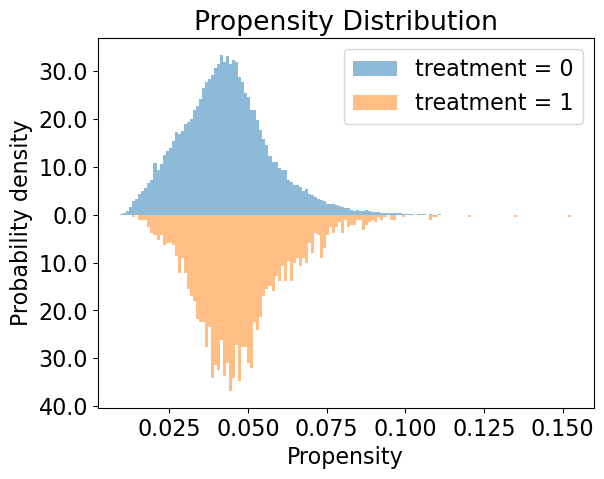

In [626]:
results1.plot_weight_distribution()

In [627]:
weights = ipw.compute_weights(data_final[feature_cols], data_final['treat'])
data_weighted = data_final.copy()
data_weighted['weights'] = weights
data_weighted.groupby('treat')['weights'].sum()

treat
0    11351.315616
1    11208.147905
Name: weights, dtype: float64

In [629]:
# concat 
data_weighted['propen_treat'] = ipw.compute_propensity_matrix(data_final[feature_cols], data_final['treat'])[1]
data_weighted['propen_control'] = ipw.compute_propensity_matrix(data_final[feature_cols], data_final['treat'])[0]

In [650]:
# data_weighted[data_weighted['treat'] == 0]['propen_control'].sort_values(ascending=False)
# data_weighted[data_weighted['treat'] == 1]['propen_treat'].sort_values(ascending=True)

geoid
48029110600    0.987214
6037134521     0.986964
6037224410     0.986863
36047044100    0.986772
6037405002     0.986482
                 ...   
6075012601     0.900348
34013016100    0.899925
17031800600    0.899027
48113019301    0.894648
17031800400    0.893871
Name: propen_control, Length: 10861, dtype: float64

In [632]:
# multiply the weights by each feature
# data_adjusted = data_weighted[feature_cols + [outcome[3]]].multiply(data_weighted['weights'], axis=0)
# data_adjusted['treat'] = data_final['treat']

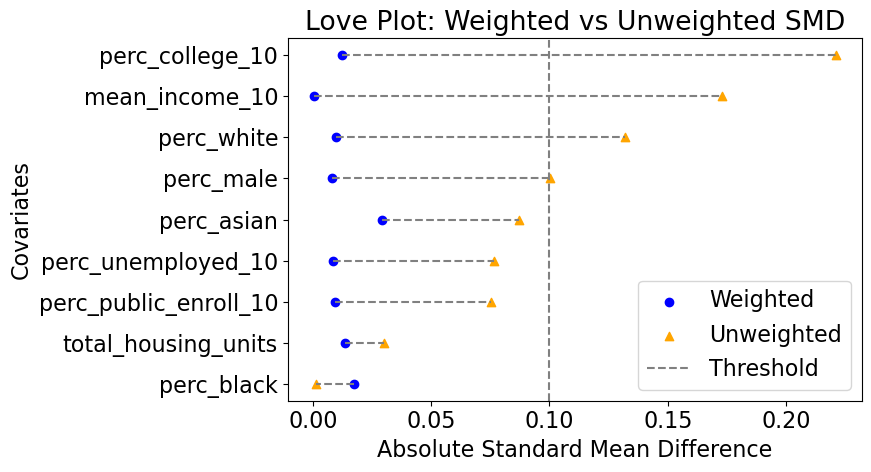

In [703]:
feature_cols = ['perc_public_enroll_10', 'mean_income_10',
                'perc_unemployed_10', 'perc_male', 'perc_white',
                 'perc_black', 'perc_asian', 'total_housing_units',
                 'perc_college_10']

outcome = ['d_owner_vac', 'd_housing_occupied', 'd_med_value','d_perc_poverty']

# Separate treatment and control groups
treated = data_weighted[data_weighted['treat'] == 1]
control = data_weighted[data_weighted['treat'] == 0]

# Means and standard deviations
mean_t = treated[feature_cols].mean()
mean_c = control[feature_cols].mean()

std_t = treated[feature_cols].std()
std_c = control[feature_cols].std()

# Pooled standard deviation
n_t = len(treated)
n_c = len(control)
pooled_std = np.sqrt(((n_t - 1) * std_t**2 + (n_c - 1) * std_c**2) / (n_t + n_c - 2))

# SMD calculation
smd = (mean_t - mean_c) / pooled_std

# Initialize lists to store the SMDs
smd_weighted = []

# Loop over each covariate and calculate the weighted SMD
for covariate in feature_cols:
    # Weighted means
    mean_t_weighted = np.average(treated[covariate], weights=treated['weights'])
    mean_c_weighted = np.average(control[covariate], weights=control['weights'])

    # Weighted pooled standard deviation
    weighted_pooled_std = np.sqrt(
        (np.sum(treated['weights'] * (treated[covariate] - mean_t_weighted)**2) +
         np.sum(control['weights'] * (control[covariate] - mean_c_weighted)**2)) / 
        (np.sum(treated['weights']) + np.sum(control['weights']) - 2)
    )

    # Weighted SMD calculation
    weighted_smd_j = (mean_t_weighted - mean_c_weighted) / weighted_pooled_std
    smd_weighted.append(weighted_smd_j)

import matplotlib.pyplot as plt

# Example covariates and their SMDs
smd_unweighted = abs(smd)  # Replace with actual SMD values for each covariate
# make the index of smd_weighted the same as feature_cols
smd_weighted = pd.Series(smd_weighted, index=smd.index)
smd_weighted = abs(smd_weighted)  # Replace with actual weighted SMDs

smd_df = pd.DataFrame({'unmatched': smd_unweighted, 'matched': smd_weighted})
smd_df = smd_df.sort_values(by='unmatched', ascending=True)

smd_unweighted = smd_df['unmatched']
smd_weighted = smd_df['matched']

# Plot
plt.figure(figsize=(9, 5))

plt.scatter(smd_weighted, smd_weighted.index, label="Weighted", color='blue', marker='o')
plt.scatter(smd_unweighted, smd_unweighted.index, label="Unweighted", color='orange', marker='^')

for i in range(len(smd_weighted.index)):
    plt.plot([smd_weighted[i], smd_unweighted[i]], [i, i], color='gray', linestyle='--')

plt.axvline(x=0.1, color="gray", linestyle="--", label='Threshold')
plt.yticks(np.arange(len(smd_unweighted.index)), smd_unweighted.index)
plt.xlabel("Absolute Standard Mean Difference")
plt.ylabel("Covariates")
plt.title("Love Plot: Weighted vs Unweighted SMD")
plt.legend(loc='best')
plt.tight_layout()
plt.show()



### PSM

In [642]:
from causallib.estimation import Matching
from causallib.preprocessing.transformers import PropensityTransformer

scaler = StandardScaler()

data_final[feature_cols] = scaler.fit_transform(data_final[feature_cols])

propensity_transform = PropensityTransformer(
    learner=LogisticRegression(
        solver="liblinear",
        class_weight="balanced"),
    include_covariates=False)

matcher = Matching(with_replacement=False, propensity_transform=propensity_transform)
matcher.fit(data_final[feature_cols], data_final['treat'], data_final[outcome[3]])
matched_data = matcher.match(data_final[feature_cols], data_final['treat'], use_cached_result=True, successful_matches_only=True)



In [746]:
# when match to treatment is 1, PSM finds a match from the treatment group for each unit no matter which group it belongs to
# when match to treament is 0, it finds a match from the control group
# but all are successful matches as we specified successful_matches_only=True
matched_data.reset_index()

match_to_treatment        geoid                 distances        matches
0                      1   6001421100  [4.8327735824416074e-05]  [27123035000]
1                      1   6037670324  [1.0311122095707503e-05]  [34013021602]
2                      1   9003497400  [2.2878135518045184e-05]   [1073004702]
3                      1  12086004105   [5.658440713540713e-06]  [34039035800]
4                      1  18097320800   [6.104886506108631e-05]  [34013021702]
...                  ...          ...                       ...            ...
1943                   0  48141002100                       [0]  [48141002100]
1944                   0  51710003501                       [0]  [51710003501]
1945                   0  51740210500                       [0]  [51740210500]
1946                   0  55079018000                       [0]  [55079018000]
1947                   0  55079186500                       [0]  [55079186500]

[1948 rows x 4 columns]

In [684]:
temp = matched_data.reset_index()
temp['matches'] = temp['matches'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
temp['distances'] = temp['distances'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
temp = temp.dropna()
temp = temp[temp['geoid'] != temp['matches']]
data_macthed = data_final.loc[temp['geoid']]
data_macthed

match_to_treatment        geoid  distances      matches
0                      1   6001421100   0.000048  27123035000
1                      1   6037670324   0.000010  34013021602
2                      1   9003497400   0.000023   1073004702
3                      1  12086004105   0.000006  34039035800
4                      1  18097320800   0.000061  34013021702
...                  ...          ...        ...          ...
1874                   0   1073000300   0.000011   6001422400
1878                   0   6001407300   0.000007  53033009400
1896                   0  17031681300   0.000005  36007013100
1910                   0  26163579300   0.000014  21111006300
1912                   0  34001001200   0.000036  29095016100

[974 rows x 4 columns]

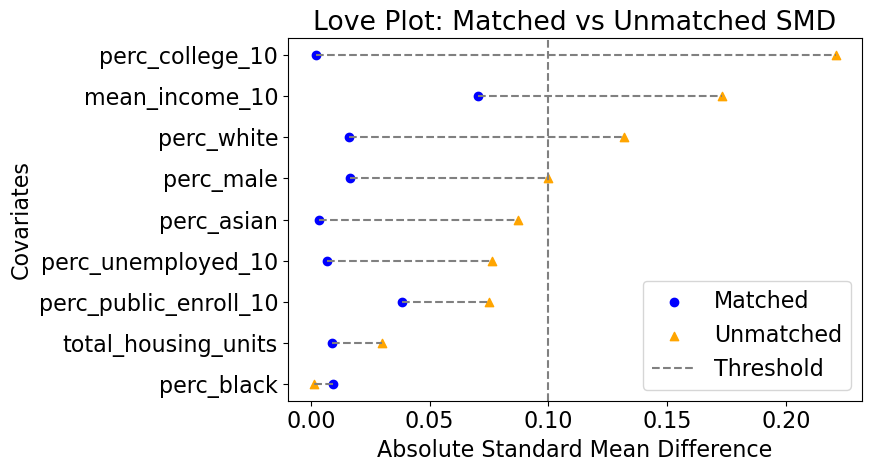

In [702]:
feature_cols = ['perc_public_enroll_10', 'mean_income_10',
                'perc_unemployed_10', 'perc_male', 'perc_white',
                 'perc_black', 'perc_asian', 'total_housing_units',
                 'perc_college_10']

outcome = ['d_owner_vac', 'd_housing_occupied', 'd_med_value','d_perc_poverty']

# Separate treatment and control groups
treated = data_final[data_final['treat'] == 1]
control = data_final[data_final['treat'] == 0]

# Means and standard deviations
mean_t = treated[feature_cols].mean()
mean_c = control[feature_cols].mean()

std_t = treated[feature_cols].std()
std_c = control[feature_cols].std()

# Pooled standard deviation
n_t = len(treated)
n_c = len(control)
pooled_std = np.sqrt(((n_t - 1) * std_t**2 + (n_c - 1) * std_c**2) / (n_t + n_c - 2))

# SMD calculation
smd = (mean_t - mean_c) / pooled_std

# Separate treatment and control groups
treated = data_macthed[data_macthed['treat'] == 1]
control = data_macthed[data_macthed['treat'] == 0]

# Means and standard deviations
mean_t = treated[feature_cols].mean()
mean_c = control[feature_cols].mean()

std_t = treated[feature_cols].std()
std_c = control[feature_cols].std()

# Pooled standard deviation
n_t = len(treated)
n_c = len(control)
pooled_std = np.sqrt(((n_t - 1) * std_t**2 + (n_c - 1) * std_c**2) / (n_t + n_c - 2))

# SMD calculation
smd_ = (mean_t - mean_c) / pooled_std

import matplotlib.pyplot as plt

# Example covariates and their SMDs
smd_unmacthed = abs(smd)  # Replace with actual SMD values for each covariate
smd_matched = abs(smd_)  # Replace with actual weighted SMDs

smd_df = pd.DataFrame({'unmatched': smd_unmacthed, 'matched': smd_matched})
smd_df = smd_df.sort_values(by='unmatched', ascending=True)

smd_unmacthed = smd_df['unmatched']
smd_matched = smd_df['matched']

# Plot
plt.figure(figsize=(9, 5))

plt.scatter(smd_matched, smd_matched.index, label="Matched", color='blue', marker='o')
plt.scatter(smd_unmacthed, smd_unmacthed.index, label="Unmatched", color='orange', marker='^')

for i in range(len(smd_unmacthed.index)):
    plt.plot([smd_matched[i], smd_unmacthed[i]], [i, i], color='gray', linestyle='--')

plt.axvline(x=0.1, color="gray", linestyle="--", label='Threshold')
plt.yticks(np.arange(len(smd_unmacthed.index)), smd_unmacthed.index)
plt.xlabel("Absolute Standard Mean Difference")
plt.ylabel("Covariates")
plt.title("Love Plot: Matched vs Unmatched SMD")
plt.legend(loc='best')
plt.tight_layout()
plt.show()



#### ATE and Bootstrap

In [843]:
# ATE: effect of increasing redlining intensity on poverty
ate_matched = np.mean(data_macthed[data_macthed['treat'] == 1]['d_perc_poverty']) - np.mean(data_macthed[data_macthed['treat'] == 0]['d_perc_poverty'])
ate_matched

0.002800821355236141

In [858]:
# bootstrap
n = 100
ate_matched_boot = []
for i in range(n):
    sample = data_final.sample(frac=1, replace=True)
    sample = sample.reset_index()
    # matching
    matcher = Matching(with_replacement=False, propensity_transform=propensity_transform)
    matcher.fit(sample[feature_cols], sample['treat'], sample[outcome[3]])
    temp_matched = matcher.match(sample[feature_cols], sample['treat'], use_cached_result=True, successful_matches_only=True)
    # clean the data
    temp = temp_matched.reset_index()
    temp['matches'] = temp['matches'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
    temp['distances'] = temp['distances'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
    temp = temp.dropna()
    temp = temp[temp.index != temp['matches']]
    temp = sample.loc[temp.index]
    # calculate ATE
    ate_matched_boot.append(np.mean(temp[temp['treat'] == 1]['d_perc_poverty']) - np.mean(temp[temp['treat'] == 0]['d_perc_poverty']))
    print(i)

ate_matched_boot = np.array(ate_matched_boot)
se = np.std(ate_matched_boot)
                            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [861]:
np.mean(ate_matched_boot), se

(0.012955920388868345, 0.01282423852339144)

### CFL

In [666]:
def build_network(trial):

    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    model = Sequential()

    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))

    return model

In [667]:
def objective(trial):

    # define the parameters for a CFL Experiment
    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

    CDE_params = {
        'model'        : 'CondExpDIY',
        'model_params' : {
            'optuna_callback' : TFKerasPruningCallback(trial, "val_loss"),
            'optuna_trial'    : trial,
            'build_network'     : build_network,

            'batch_size'      : trial.suggest_int("batch_size", 16, 128),
            'n_epochs'        : 100,
            'optimizer'       : 'adam',
            'opt_config'      : {'learning_rate' : trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)},
            'loss'            : 'mean_squared_error',
            'best'            : True,
            'verbose'         : 0,
            'early_stopping'  : True,
        }
    }

    block_names = ['CondDensityEstimator']
    block_params = [CDE_params]

    my_exp = Experiment(X_train=X,
                        Y_train=Y,
                        in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx,
                        data_info=data_info,
                        block_names=block_names,
                        block_params=block_params,
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    train_results = my_exp.train()
    score = train_results['CondDensityEstimator']['val_loss'][-1]
    return score

In [786]:
Y = data_macthed[outcome[3]].values.reshape(-1, 1)
# X = data_adjusted.drop(columns=['treat']).values
X = data_macthed[feature_cols + ['treat']].values

# split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# get the indices of the training and testing data
in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

print(X.shape)
print(Y.shape)

(974, 10)
(974, 1)


[I 2024-10-19 09:39:27,591] A new study created in memory with name: no-name-6d011fce-1c92-4f93-85ab-518cd60a04a7


Block: verbose not specified in input, defaulting to 1


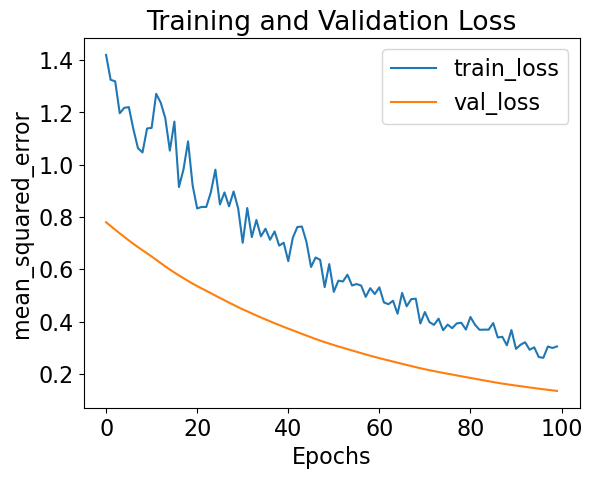

31/31 [==============================] - 0s 1ms/step


[I 2024-10-19 09:39:48,729] Trial 0 finished with value: 0.1349434107542038 and parameters: {'batch_size': 108, 'learning_rate': 0.00018310101886531152, 'n_layers': 1, 'n_units_l0': 7, 'dropout_l0': 0.46086133373004873}. Best is trial 0 with value: 0.1349434107542038.


Block: verbose not specified in input, defaulting to 1


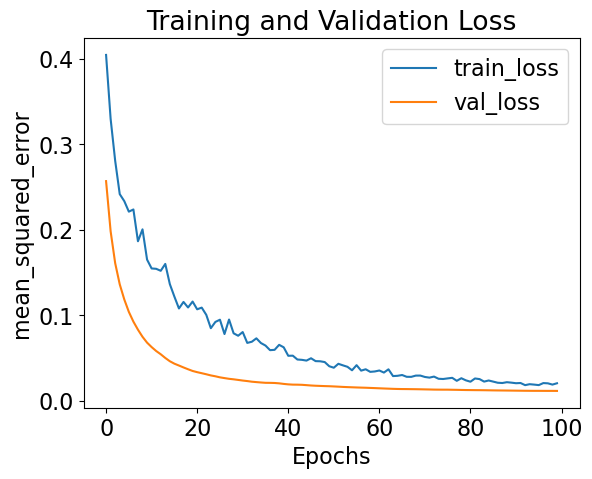

31/31 [==============================] - 0s 1ms/step


[I 2024-10-19 09:40:03,828] Trial 1 finished with value: 0.011719522066414356 and parameters: {'batch_size': 82, 'learning_rate': 0.0004926482841161027, 'n_layers': 1, 'n_units_l0': 49, 'dropout_l0': 0.4091376780575601}. Best is trial 1 with value: 0.011719522066414356.


Block: verbose not specified in input, defaulting to 1


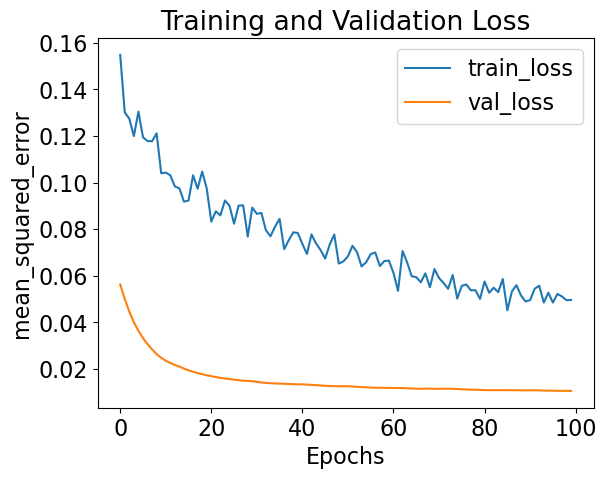

31/31 [==============================] - 0s 3ms/step


[I 2024-10-19 09:40:20,065] Trial 2 finished with value: 0.010554942302405834 and parameters: {'batch_size': 76, 'learning_rate': 2.3992911149458122e-05, 'n_layers': 2, 'n_units_l0': 108, 'dropout_l0': 0.27237216210311366, 'n_units_l1': 176, 'dropout_l1': 0.49509357865311343}. Best is trial 2 with value: 0.010554942302405834.


Block: verbose not specified in input, defaulting to 1


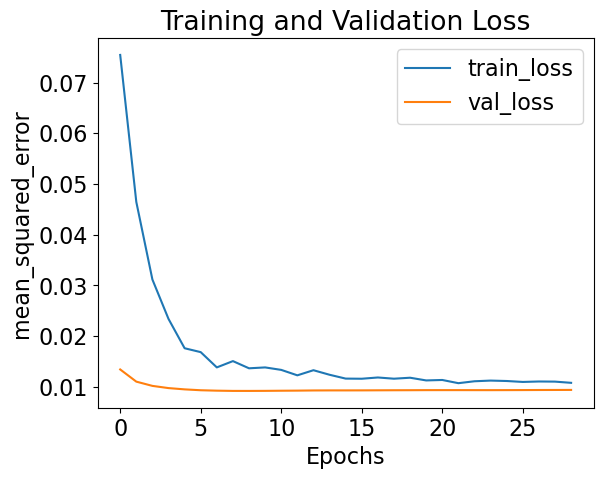

31/31 [==============================] - 0s 2ms/step


[I 2024-10-19 09:40:26,405] Trial 3 finished with value: 0.009387390688061714 and parameters: {'batch_size': 114, 'learning_rate': 0.0009105205447029732, 'n_layers': 4, 'n_units_l0': 7, 'dropout_l0': 0.12924541856242128, 'n_units_l1': 75, 'dropout_l1': 0.26373140566371384, 'n_units_l2': 97, 'dropout_l2': 0.421943419116175, 'n_units_l3': 31, 'dropout_l3': 0.31012634479692225}. Best is trial 3 with value: 0.009387390688061714.


Block: verbose not specified in input, defaulting to 1


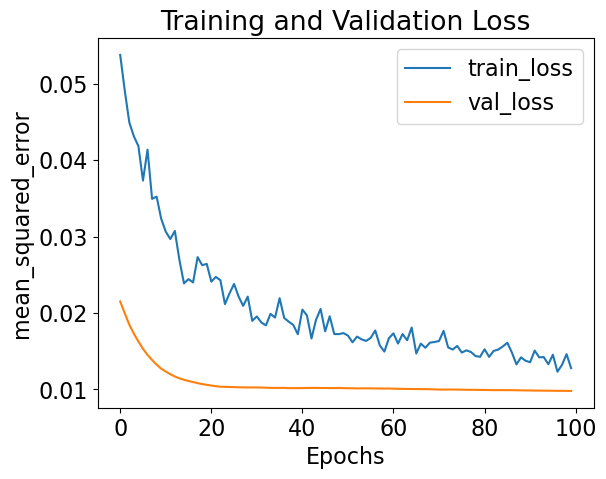

31/31 [==============================] - 0s 3ms/step


[I 2024-10-19 09:41:23,166] Trial 4 finished with value: 0.009789782576262951 and parameters: {'batch_size': 27, 'learning_rate': 1.6112355664567792e-05, 'n_layers': 4, 'n_units_l0': 71, 'dropout_l0': 0.18855118530155157, 'n_units_l1': 10, 'dropout_l1': 0.2979034311575027, 'n_units_l2': 39, 'dropout_l2': 0.13322819654769824, 'n_units_l3': 25, 'dropout_l3': 0.21233117358341846}. Best is trial 3 with value: 0.009387390688061714.


Block: verbose not specified in input, defaulting to 1


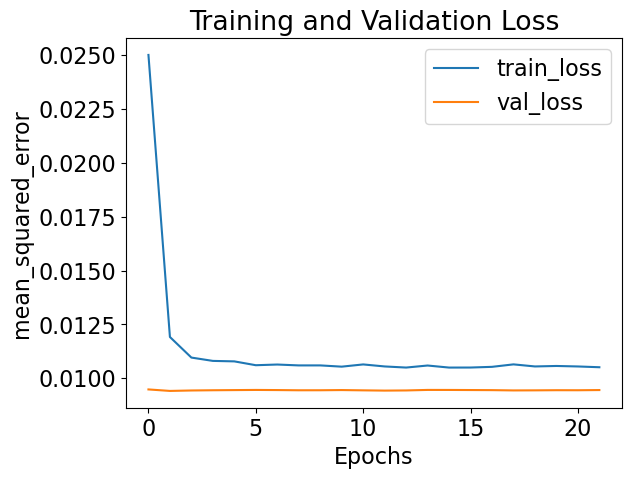

31/31 [==============================] - 0s 3ms/step


[I 2024-10-19 09:41:29,937] Trial 5 finished with value: 0.00944665540009737 and parameters: {'batch_size': 64, 'learning_rate': 0.0005170817205001373, 'n_layers': 5, 'n_units_l0': 78, 'dropout_l0': 0.2216301871991383, 'n_units_l1': 186, 'dropout_l1': 0.2978083247487715, 'n_units_l2': 135, 'dropout_l2': 0.10970816256509303, 'n_units_l3': 8, 'dropout_l3': 0.0876687958131388, 'n_units_l4': 16, 'dropout_l4': 0.47180703967124493}. Best is trial 3 with value: 0.009387390688061714.


Block: verbose not specified in input, defaulting to 1


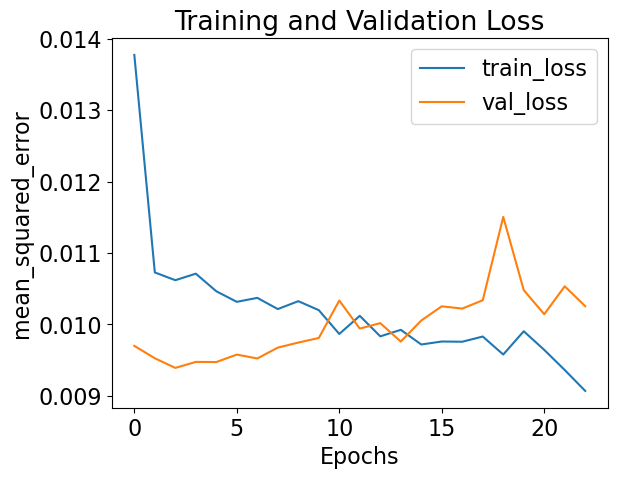

31/31 [==============================] - 0s 2ms/step


[I 2024-10-19 09:41:36,776] Trial 6 finished with value: 0.010255392640829086 and parameters: {'batch_size': 18, 'learning_rate': 0.0008239427355971748, 'n_layers': 4, 'n_units_l0': 289, 'dropout_l0': 0.1522949954786454, 'n_units_l1': 11, 'dropout_l1': 0.18269334727629, 'n_units_l2': 42, 'dropout_l2': 0.2923013852131171, 'n_units_l3': 57, 'dropout_l3': 0.06702350903968074}. Best is trial 3 with value: 0.009387390688061714.


Block: verbose not specified in input, defaulting to 1


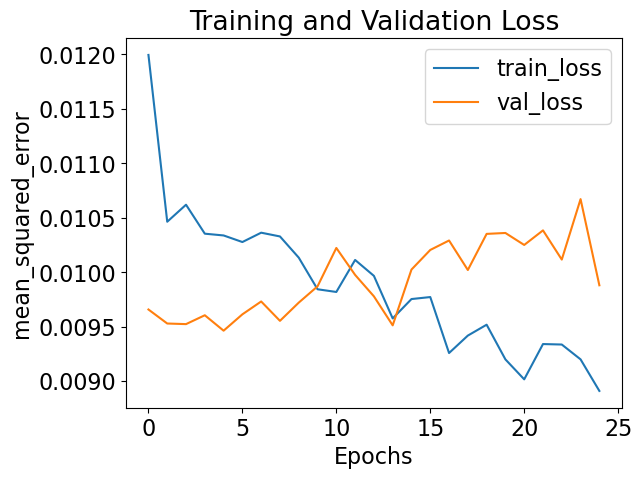

31/31 [==============================] - 0s 4ms/step


[I 2024-10-19 09:41:43,654] Trial 7 finished with value: 0.009880783967673779 and parameters: {'batch_size': 18, 'learning_rate': 0.0004130800041610164, 'n_layers': 3, 'n_units_l0': 336, 'dropout_l0': 0.1511593133960777, 'n_units_l1': 12, 'dropout_l1': 0.08280874423202839, 'n_units_l2': 81, 'dropout_l2': 0.3087736274064058}. Best is trial 3 with value: 0.009387390688061714.


Block: verbose not specified in input, defaulting to 1


[I 2024-10-19 09:41:46,734] Trial 8 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


[I 2024-10-19 09:41:47,801] Trial 9 pruned. Trial was pruned at epoch 0.


In [787]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)

In [788]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  2
  Number of complete trials:  8
Best trial:
  Value:  0.009387390688061714
  Params: 
    batch_size: 114
    learning_rate: 0.0009105205447029732
    n_layers: 4
    n_units_l0: 7
    dropout_l0: 0.12924541856242128
    n_units_l1: 75
    dropout_l1: 0.26373140566371384
    n_units_l2: 97
    dropout_l2: 0.421943419116175
    n_units_l3: 31
    dropout_l3: 0.31012634479692225


#### 3 clusters

save_path 'demo_results' doesn't exist, creating now.
All results from this run will be saved to demo_results\experiment0000
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


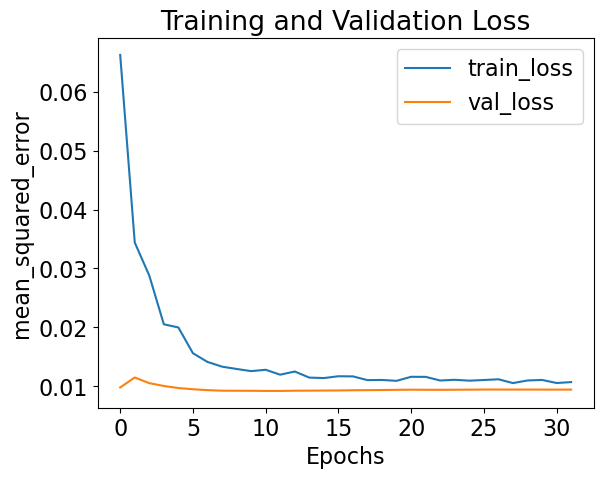

31/31 [==============================] - 0s 2ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [789]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd


In [792]:
temp = data_final_unstandardized.loc[data_macthed.reset_index()['geoid']]
data_cluster = pd.merge(temp.reset_index(drop=True), pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})


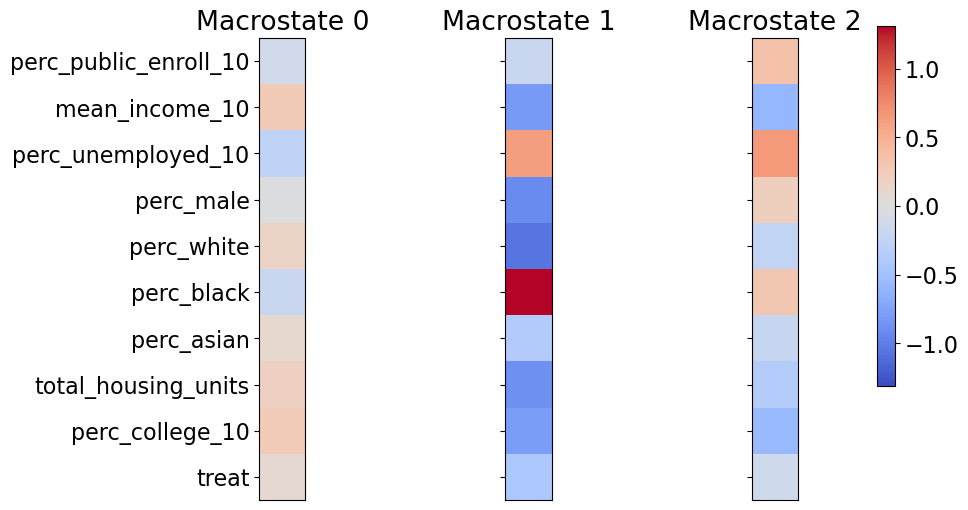

In [793]:
# visualize cause side macrostates
column = feature_cols + ['treat']
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0000', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

In [794]:
data_cluster['cluster'].value_counts()


0    687
2    242
1     45
Name: cluster, dtype: int64

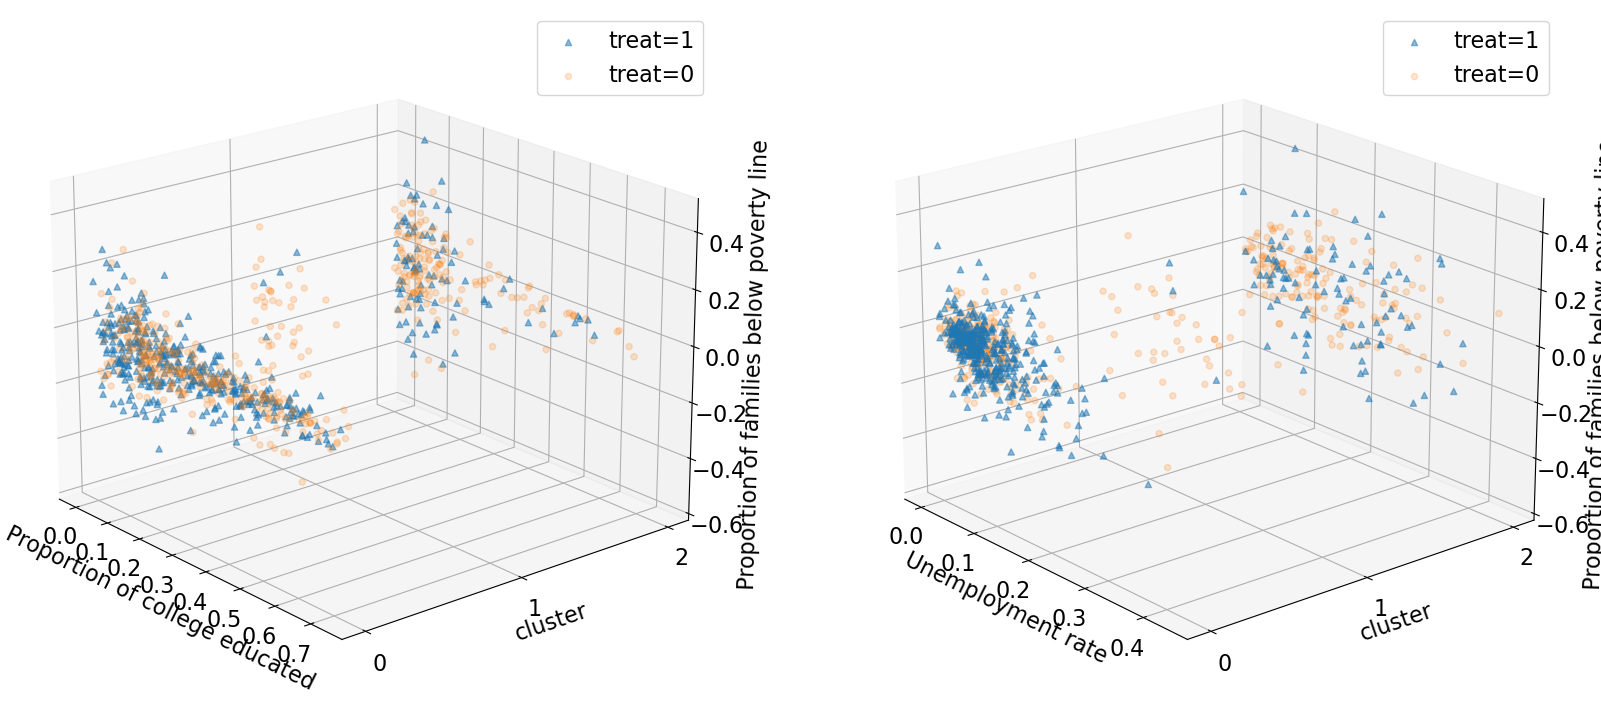

In [800]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,40))

ax = fig.add_subplot(1, 2, 1,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_college_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_perc_poverty'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_college_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_perc_poverty'], marker = 'o', label = 'treat=0', alpha = 0.2)
# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks([0,1,2])
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('Proportion of college educated')
ax.set_ylabel('cluster')
ax.set_zlabel('Proportion of families below poverty line')
ax.view_init(elev=20, azim=-40)
ax.legend()

ax = fig.add_subplot(1, 2, 2,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_unemployed_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_perc_poverty'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_unemployed_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_perc_poverty'], marker = 'o', label = 'treat=0', alpha = 0.2)
ax.set_yticks([0,1,2])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('Unemployment rate')
ax.set_ylabel('cluster')
ax.set_zlabel('Proportion of families below poverty line')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-40)
ax.legend()
plt.savefig('poverty_unemployment_college_3_cl.png')
plt.show()


#### 6 clusters

All results from this run will be saved to demo_results\experiment0001
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


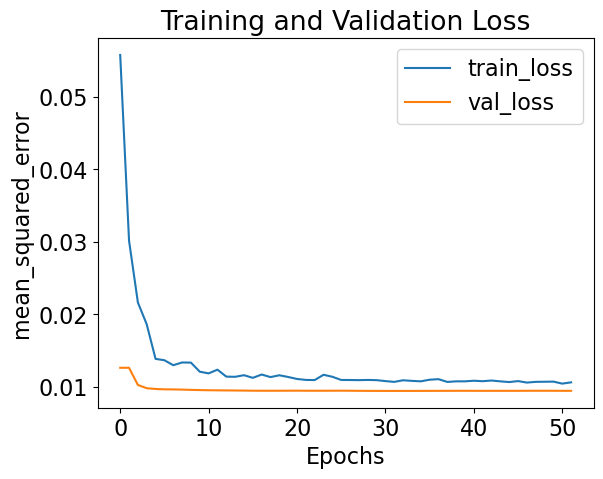

31/31 [==============================] - 0s 2ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [801]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 6},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd


In [802]:
temp = data_final_unstandardized.loc[data_macthed.reset_index()['geoid']]
data_cluster = pd.merge(temp.reset_index(drop=True), pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})

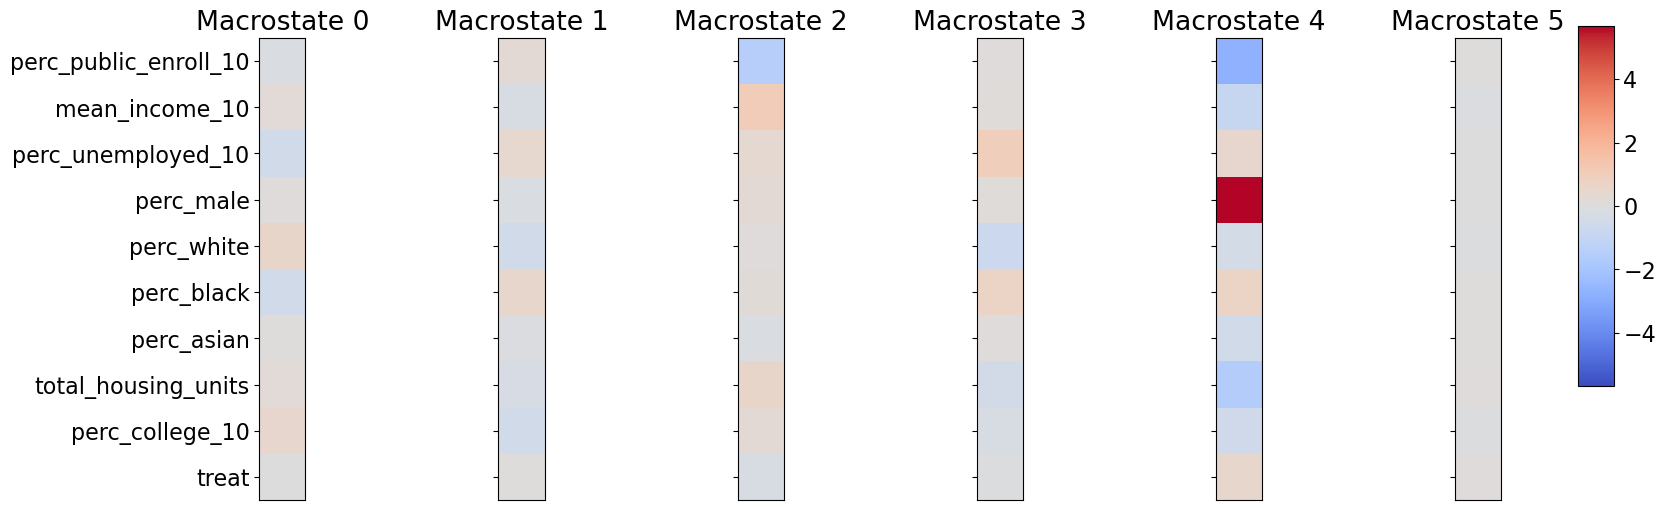

In [803]:
# visualize cause side macrostates
column = feature_cols + ['treat']
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0001', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

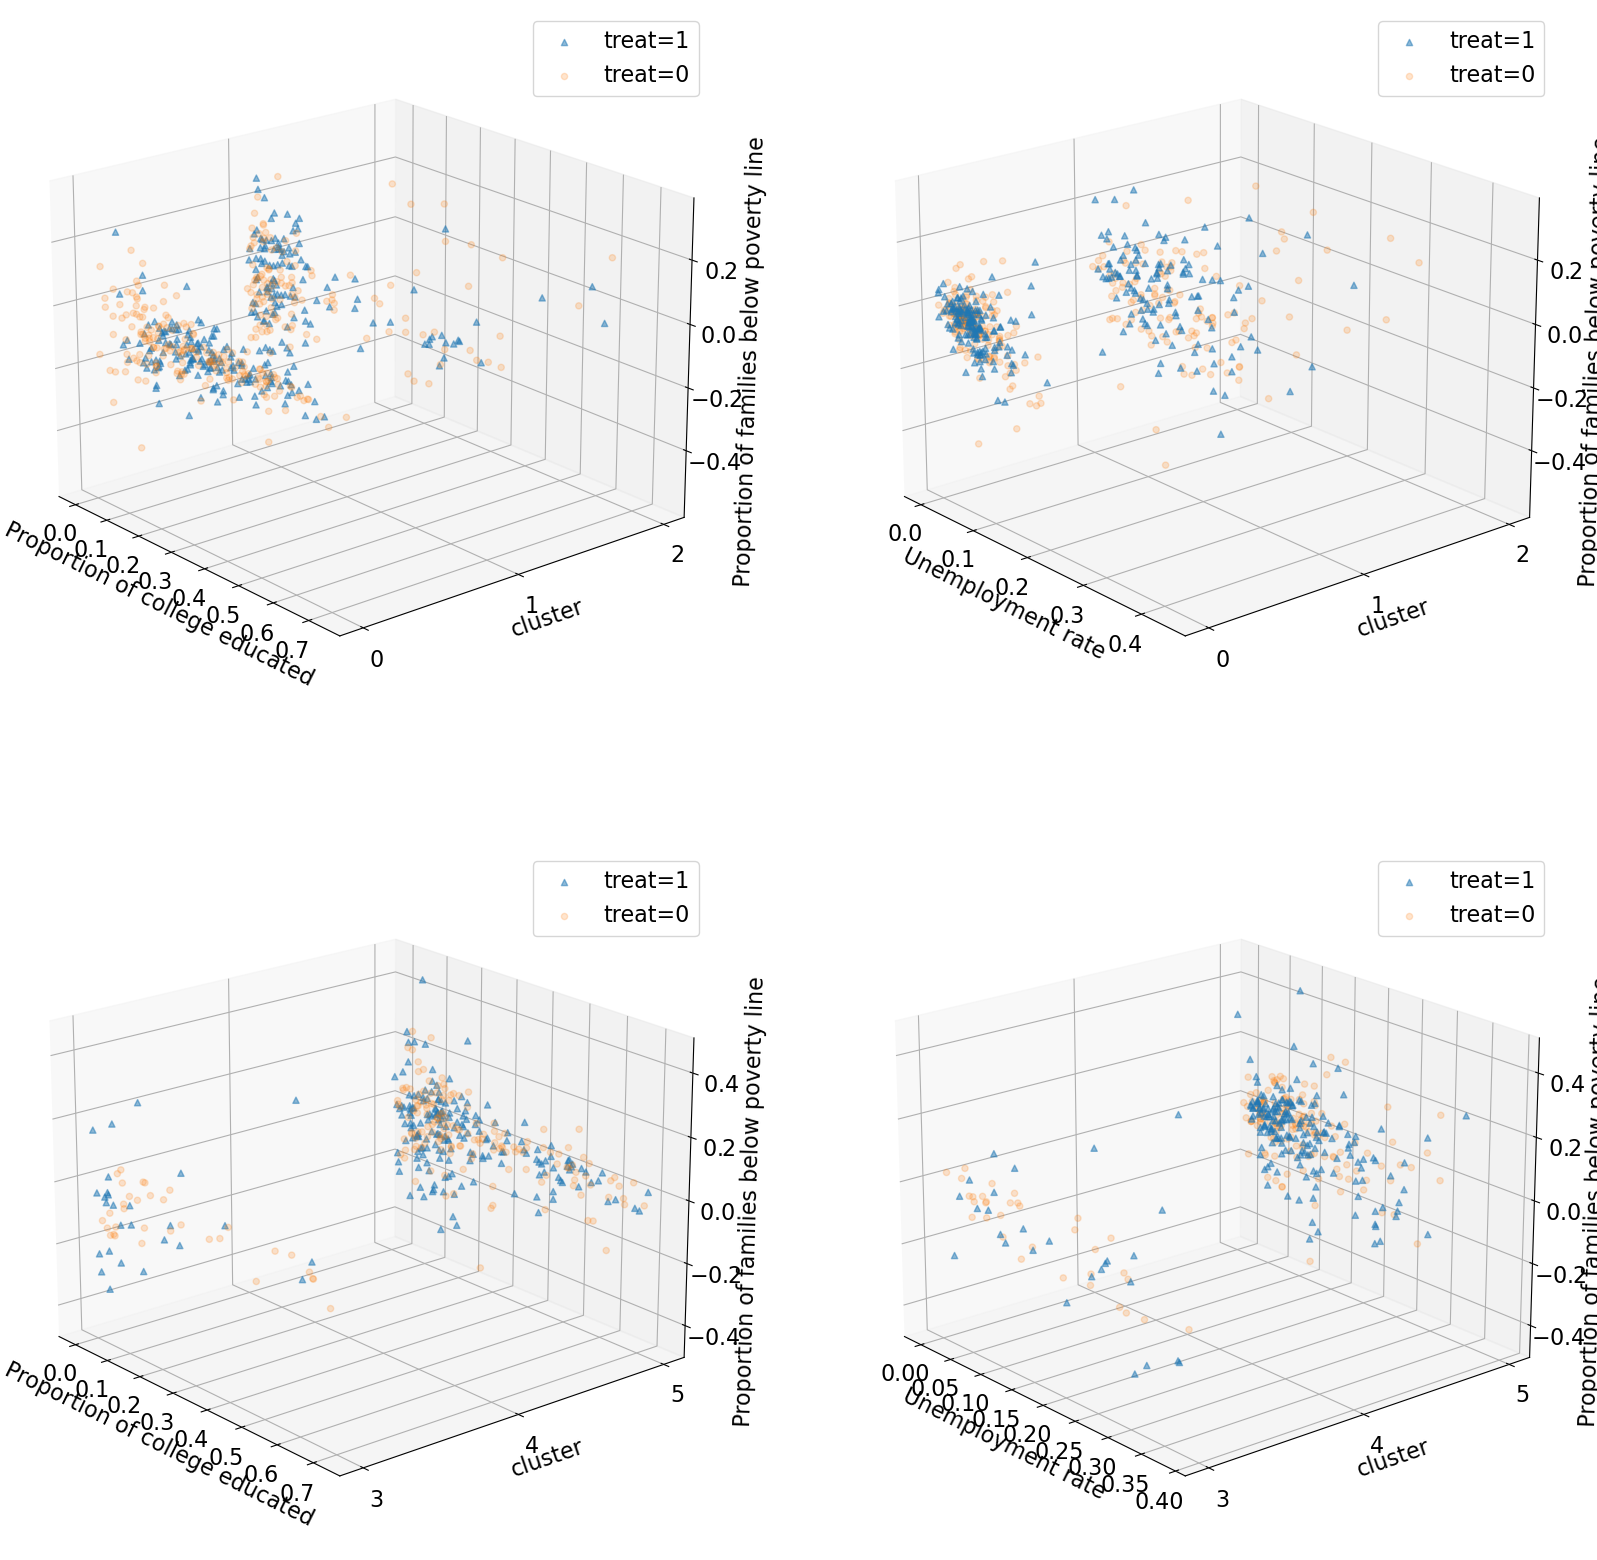

In [816]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,20))

##
# First Row
##

ax = fig.add_subplot(2, 2, 1,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['d_perc_poverty'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['d_perc_poverty'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks(np.arange(0,3,1))
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('Proportion of college educated')
ax.set_ylabel('cluster')
ax.set_zlabel('Proportion of families below poverty line')
ax.view_init(elev=20, azim=-40)
ax.legend()



ax = fig.add_subplot(2, 2, 2,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['d_perc_poverty'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['d_perc_poverty'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

ax.set_yticks(np.arange(0,3,1))
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('Unemployment rate')
ax.set_ylabel('cluster')
ax.set_zlabel('Proportion of families below poverty line')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-40)
ax.legend()


##
# Second Row
##


ax = fig.add_subplot(2, 2, 3,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['d_perc_poverty'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['d_perc_poverty'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks(np.arange(3,6,1))
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('Proportion of college educated')
ax.set_ylabel('cluster')
ax.set_zlabel('Proportion of families below poverty line')
ax.view_init(elev=20, azim=-40)
ax.legend()



ax = fig.add_subplot(2, 2, 4,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['d_perc_poverty'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['d_perc_poverty'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

ax.set_yticks(np.arange(3,6,1))
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('Unemployment rate')
ax.set_ylabel('cluster')
ax.set_zlabel('Proportion of families below poverty line')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-40)
ax.legend()


plt.savefig('poverty_unemployment_college_6_cl.png')
plt.show()


## Value of house

### IPW

In [727]:
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from causallib.datasets import load_nhefs
import matplotlib.pyplot as plt
# import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# suppress warnings
import warnings
warnings.filterwarnings("ignore")
data_final = data_final_unstandardized.copy()

# standardize the data
scaler = StandardScaler()
data_final[feature_cols] = scaler.fit_transform(data_final[feature_cols])

ipw = IPW(LogisticRegression(solver="liblinear", max_iter=5000))

results1 = evaluate(ipw, data_final[feature_cols], data_final['treat'], data_final[outcome[2]], cv="auto")
# ax = plt.gca()
# results1.plot_covariate_balance(kind="love", ax=ax, thresh=0.05)

# plt.show()

In [728]:
ipw.fit(data_final[feature_cols], data_final['treat'])

IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.4/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=5000, solver='liblinear'))

In [729]:
outcomes = ipw.estimate_population_outcome(data_final[feature_cols], data_final['treat'], data_final[outcome[2]])
effect = ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=["diff"])
effect

diff   -26237.105616
dtype: float64

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

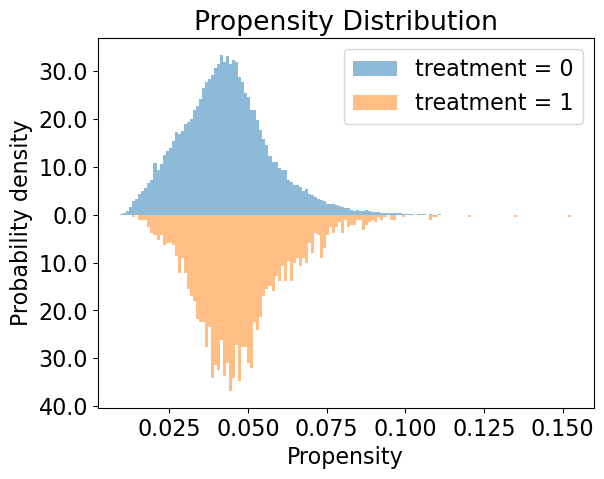

In [730]:
results1.plot_weight_distribution()

In [731]:
weights = ipw.compute_weights(data_final[feature_cols], data_final['treat'])
data_final['weights'] = weights
data_final.groupby('treat')['weights'].sum()

treat
0    11351.315616
1    11208.147905
Name: weights, dtype: float64

In [732]:

# multiply the weights by each feature
data_adjusted = data_final[feature_cols].multiply(data_final['weights'], axis=0)
data_adjusted['treat'] = data_final['treat']

### PSM

In [ ]:
from causallib.estimation import Matching
from causallib.preprocessing.transformers import PropensityTransformer

scaler = StandardScaler()

data_final[feature_cols] = scaler.fit_transform(data_final[feature_cols])

propensity_transform = PropensityTransformer(
    learner=LogisticRegression(
        solver="liblinear",
        class_weight="balanced"),
    include_covariates=False)

matcher = Matching(with_replacement=False, propensity_transform=propensity_transform)
matcher.fit(data_final[feature_cols], data_final['treat'], data_final[outcome[3]])
matched_data = matcher.match(data_final[feature_cols], data_final['treat'], use_cached_result=True, successful_matches_only=True)

# when match to treatment is 1, PSM finds a match from the treatment group for each unit no matter which group it belongs to
# when match to treament is 0, it finds a match from the control group
# but all are successful matches as we specified successful_matches_only=True
matched_data.reset_index()

In [ ]:
temp = matched_data.reset_index()
temp['matches'] = temp['matches'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
temp['distances'] = temp['distances'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
temp = temp.dropna()
temp = temp[temp['geoid'] != temp['matches']]
data_macthed = data_final.loc[temp['geoid']]
data_macthed

#### ATE and Bootstrap

In [862]:
# ATE: effect of increasing redlining intensity on poverty
ate_matched = np.mean(data_macthed[data_macthed['treat'] == 1]['d_med_value']) - np.mean(data_macthed[data_macthed['treat'] == 0]['d_med_value'])
ate_matched

-22599.257016018877

In [863]:
# bootstrap
n = 100
ate_matched_boot = []
for i in range(n):
    sample = data_final.sample(frac=1, replace=True)
    sample = sample.reset_index()
    # matching
    matcher = Matching(with_replacement=False, propensity_transform=propensity_transform)
    matcher.fit(sample[feature_cols], sample['treat'], sample[outcome[3]])
    temp_matched = matcher.match(sample[feature_cols], sample['treat'], use_cached_result=True, successful_matches_only=True)
    # clean the data
    temp = temp_matched.reset_index()
    temp['matches'] = temp['matches'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
    temp['distances'] = temp['distances'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
    temp = temp.dropna()
    temp = temp[temp.index != temp['matches']]
    temp = sample.loc[temp.index]
    # calculate ATE
    ate_matched_boot.append(np.mean(temp[temp['treat'] == 1]['d_med_value']) - np.mean(temp[temp['treat'] == 0]['d_med_value']))
    print(i)

ate_matched_boot = np.array(ate_matched_boot)
se = np.std(ate_matched_boot)
                            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [865]:
np.mean(ate_matched_boot), se

(-19914.296000904757, 14928.390585752371)

In [866]:
-22599.257016018877/se

-1.513844167340287

### CFL

In [817]:
Y = data_macthed[outcome[2]].values.reshape(-1, 1)
# X = data_adjusted.drop(columns=['treat']).values
X = data_macthed[feature_cols + ['treat']].values

# split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# get the indices of the training and testing data
in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

print(X.shape)
print(Y.shape)

(974, 10)
(974, 1)


[I 2024-10-19 10:04:16,217] A new study created in memory with name: no-name-fa687b5b-fdfc-438d-b640-16438a420073


Block: verbose not specified in input, defaulting to 1


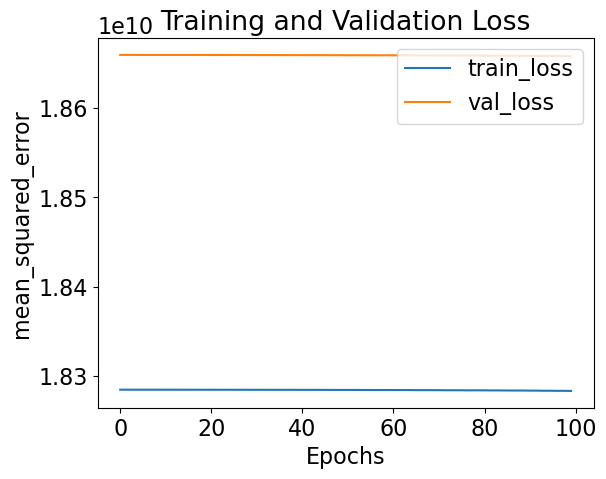

31/31 [==============================] - 0s 3ms/step


[I 2024-10-19 10:04:38,715] Trial 0 finished with value: 18658191360.0 and parameters: {'batch_size': 71, 'learning_rate': 6.327282796894945e-05, 'n_layers': 2, 'n_units_l0': 33, 'dropout_l0': 0.2168990462108713, 'n_units_l1': 447, 'dropout_l1': 0.4435069434535909}. Best is trial 0 with value: 18658191360.0.


Block: verbose not specified in input, defaulting to 1


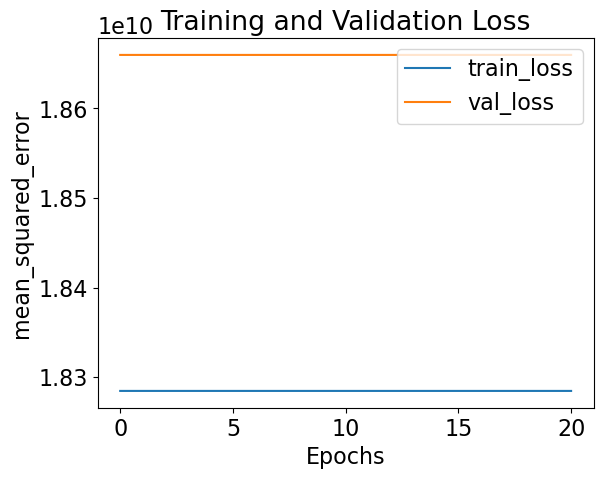

31/31 [==============================] - 0s 3ms/step


[I 2024-10-19 10:04:43,851] Trial 1 finished with value: 18659616768.0 and parameters: {'batch_size': 108, 'learning_rate': 0.00012498708064324148, 'n_layers': 5, 'n_units_l0': 43, 'dropout_l0': 0.49842738270523024, 'n_units_l1': 10, 'dropout_l1': 0.382149641352483, 'n_units_l2': 5, 'dropout_l2': 0.25425586534553035, 'n_units_l3': 4, 'dropout_l3': 0.31426598958840535, 'n_units_l4': 4, 'dropout_l4': 0.3982504822705014}. Best is trial 0 with value: 18658191360.0.


Block: verbose not specified in input, defaulting to 1


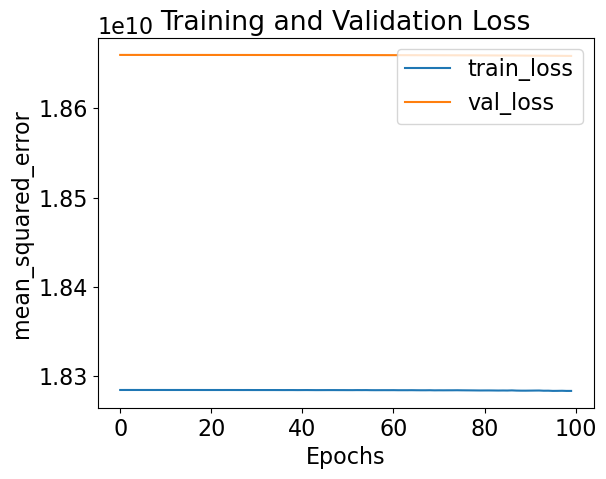

31/31 [==============================] - 0s 4ms/step


[I 2024-10-19 10:05:28,831] Trial 2 finished with value: 18658496512.0 and parameters: {'batch_size': 52, 'learning_rate': 8.760769446217459e-05, 'n_layers': 3, 'n_units_l0': 26, 'dropout_l0': 0.1367651865890122, 'n_units_l1': 369, 'dropout_l1': 0.49785128383195754, 'n_units_l2': 5, 'dropout_l2': 0.25813174794551635}. Best is trial 0 with value: 18658191360.0.


Block: verbose not specified in input, defaulting to 1


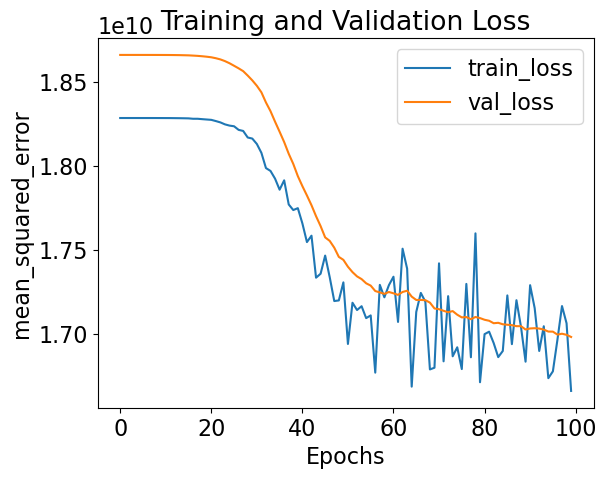

31/31 [==============================] - 1s 7ms/step


[I 2024-10-19 10:06:21,008] Trial 3 finished with value: 16983264256.0 and parameters: {'batch_size': 30, 'learning_rate': 0.00019099410904688374, 'n_layers': 5, 'n_units_l0': 18, 'dropout_l0': 0.15674089569777622, 'n_units_l1': 382, 'dropout_l1': 0.10182356940008047, 'n_units_l2': 7, 'dropout_l2': 0.4633287020799754, 'n_units_l3': 168, 'dropout_l3': 0.0764574954632406, 'n_units_l4': 5, 'dropout_l4': 0.14737670693317306}. Best is trial 3 with value: 16983264256.0.


Block: verbose not specified in input, defaulting to 1


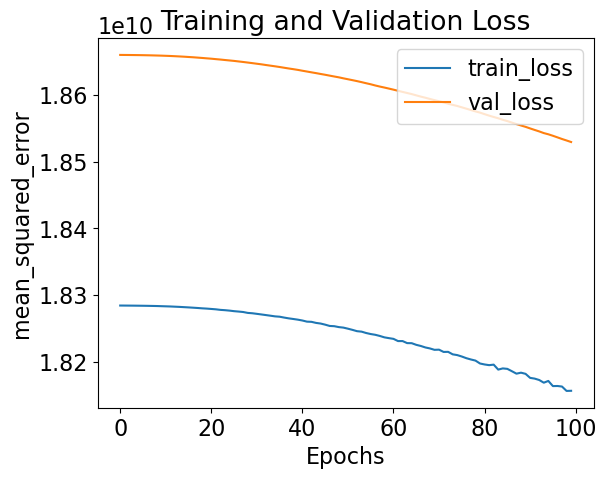

31/31 [==============================] - 0s 3ms/step


[I 2024-10-19 10:06:57,916] Trial 4 finished with value: 18529249280.0 and parameters: {'batch_size': 42, 'learning_rate': 0.0008491701047053477, 'n_layers': 1, 'n_units_l0': 284, 'dropout_l0': 0.4213734778071415}. Best is trial 3 with value: 16983264256.0.


Block: verbose not specified in input, defaulting to 1


[I 2024-10-19 10:07:01,939] Trial 5 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


[I 2024-10-19 10:07:06,664] Trial 6 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


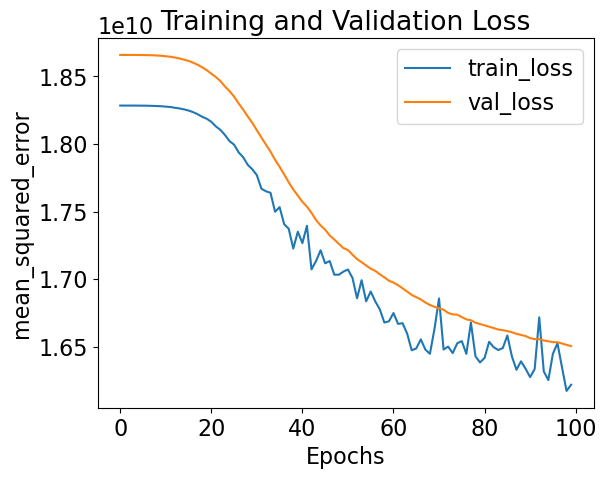

31/31 [==============================] - 0s 2ms/step


[I 2024-10-19 10:07:38,613] Trial 7 finished with value: 16503888896.0 and parameters: {'batch_size': 19, 'learning_rate': 0.0003971533319972678, 'n_layers': 3, 'n_units_l0': 13, 'dropout_l0': 0.09235289535925051, 'n_units_l1': 261, 'dropout_l1': 0.24983544021528742, 'n_units_l2': 22, 'dropout_l2': 0.37754830757826624}. Best is trial 7 with value: 16503888896.0.


Block: verbose not specified in input, defaulting to 1


[I 2024-10-19 10:07:40,206] Trial 8 pruned. Trial was pruned at epoch 0.


Block: verbose not specified in input, defaulting to 1


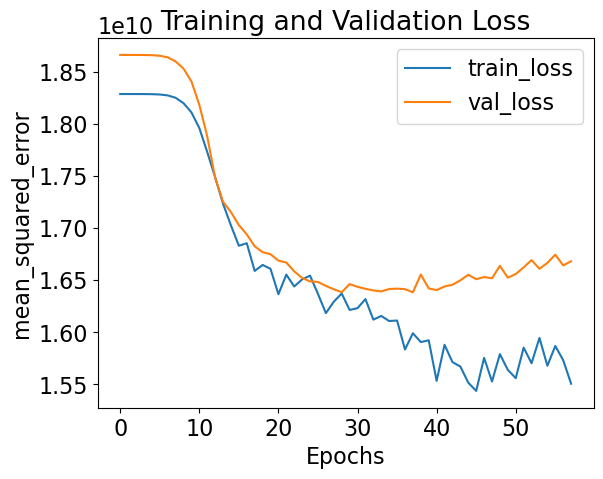

31/31 [==============================] - 0s 3ms/step


[I 2024-10-19 10:07:53,886] Trial 9 finished with value: 16680983552.0 and parameters: {'batch_size': 40, 'learning_rate': 0.00047917776220134805, 'n_layers': 5, 'n_units_l0': 65, 'dropout_l0': 0.12057313479593335, 'n_units_l1': 16, 'dropout_l1': 0.05031938755124826, 'n_units_l2': 441, 'dropout_l2': 0.3625693265364076, 'n_units_l3': 125, 'dropout_l3': 0.015550016070582817, 'n_units_l4': 75, 'dropout_l4': 0.33428784715601373}. Best is trial 7 with value: 16503888896.0.


In [818]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)

In [819]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  3
  Number of complete trials:  7
Best trial:
  Value:  16503888896.0
  Params: 
    batch_size: 19
    learning_rate: 0.0003971533319972678
    n_layers: 3
    n_units_l0: 13
    dropout_l0: 0.09235289535925051
    n_units_l1: 261
    dropout_l1: 0.24983544021528742
    n_units_l2: 22
    dropout_l2: 0.37754830757826624


#### 3 clusters

All results from this run will be saved to demo_results\experiment0002
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


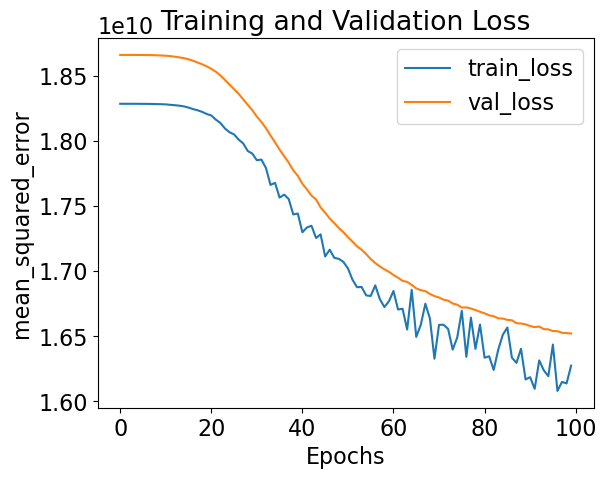

31/31 [==============================] - 0s 4ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [820]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd


In [821]:
temp = data_final_unstandardized.loc[data_macthed.reset_index()['geoid']]
data_cluster = pd.merge(temp.reset_index(drop=True), pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})


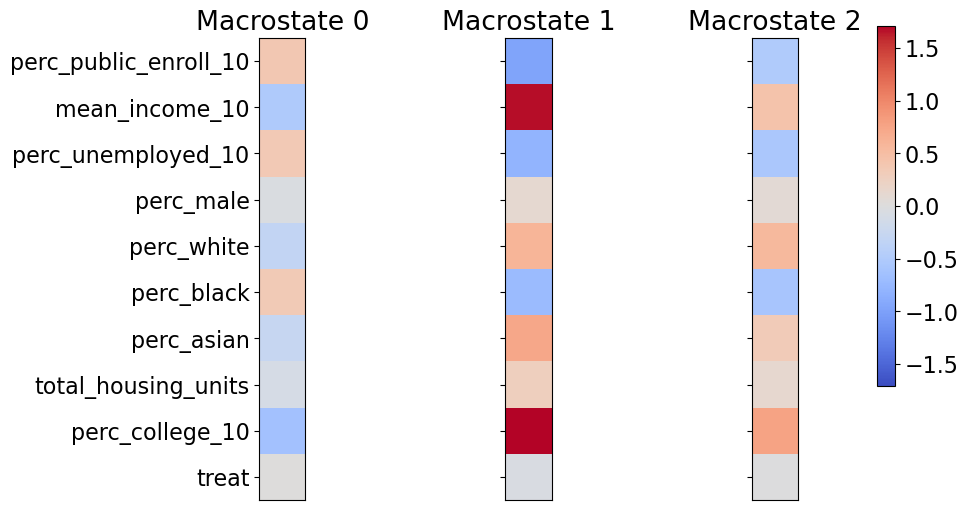

In [823]:
# visualize cause side macrostates
column = feature_cols + ['treat']
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0002', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

In [824]:
data_cluster['cluster'].value_counts()

0    630
2    202
1    142
Name: cluster, dtype: int64

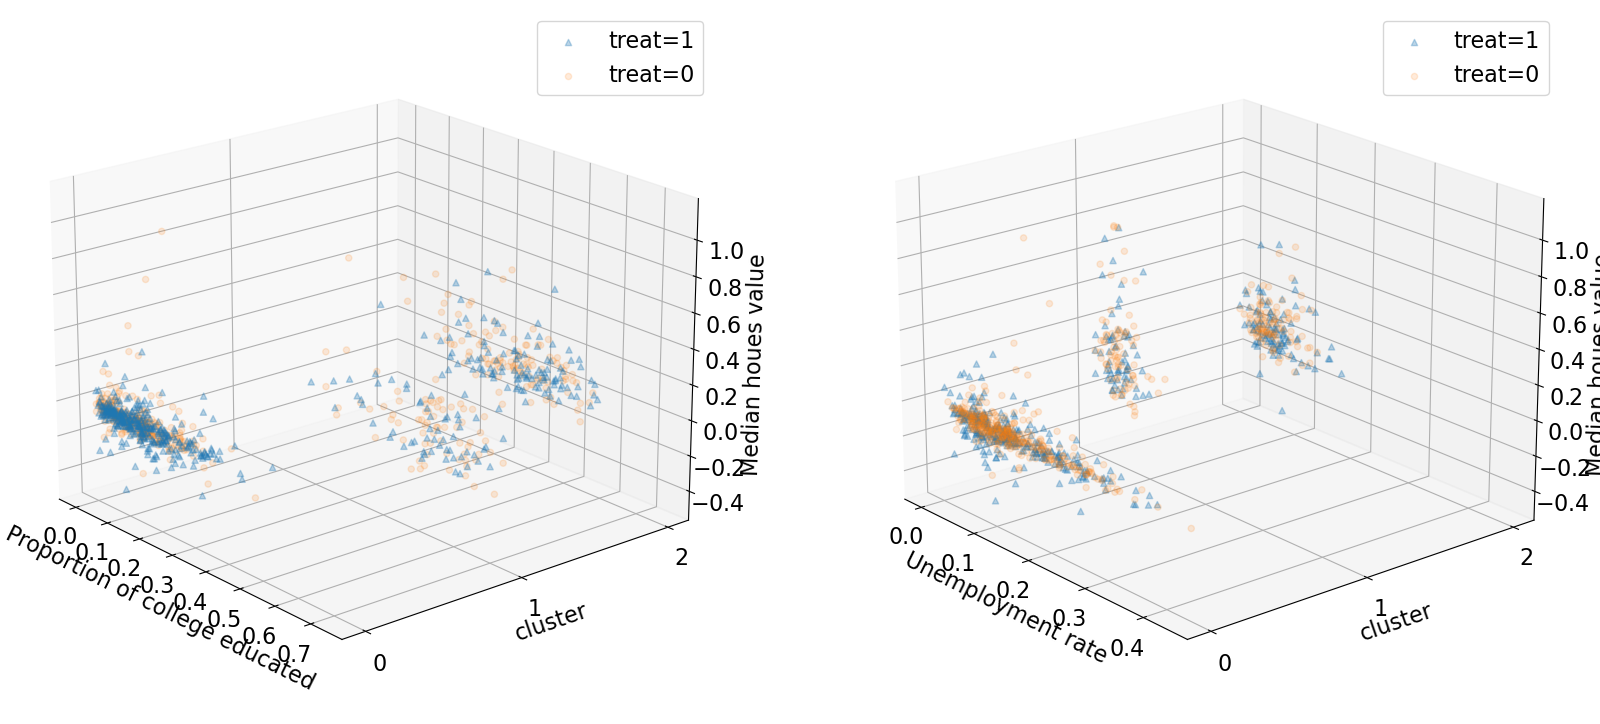

In [832]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,40))

ax = fig.add_subplot(1, 2, 1,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_college_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_med_value'], marker = '^', label = 'treat=1', alpha = 0.3)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_college_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_med_value'], marker = 'o', label = 'treat=0', alpha = 0.15)
# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks([0,1,2])
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('Proportion of college educated')
ax.set_ylabel('cluster')
ax.set_zlabel('Median houes value')
ax.view_init(elev=20, azim=-40)
ax.legend()

ax = fig.add_subplot(1, 2, 2,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_unemployed_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_med_value'], marker = '^', label = 'treat=1', alpha = 0.3)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_unemployed_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_med_value'], marker = 'o', label = 'treat=0', alpha = 0.15)
ax.set_yticks([0,1,2])
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('Unemployment rate')
ax.set_ylabel('cluster')
ax.set_zlabel('Median houes value')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-40)
ax.legend()
plt.savefig('value_unemployment_college_3_cl.png')
plt.show()


#### 6 clusters

All results from this run will be saved to demo_results\experiment0003
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


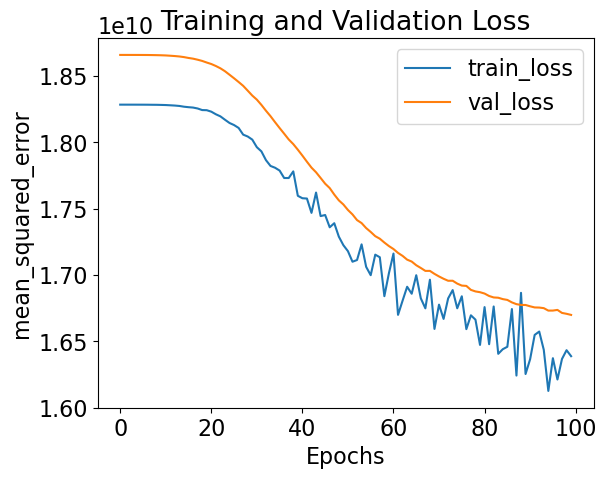

31/31 [==============================] - 0s 2ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [833]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 6},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd


In [834]:
temp = data_final_unstandardized.loc[data_macthed.reset_index()['geoid']]
data_cluster = pd.merge(temp.reset_index(drop=True), pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})


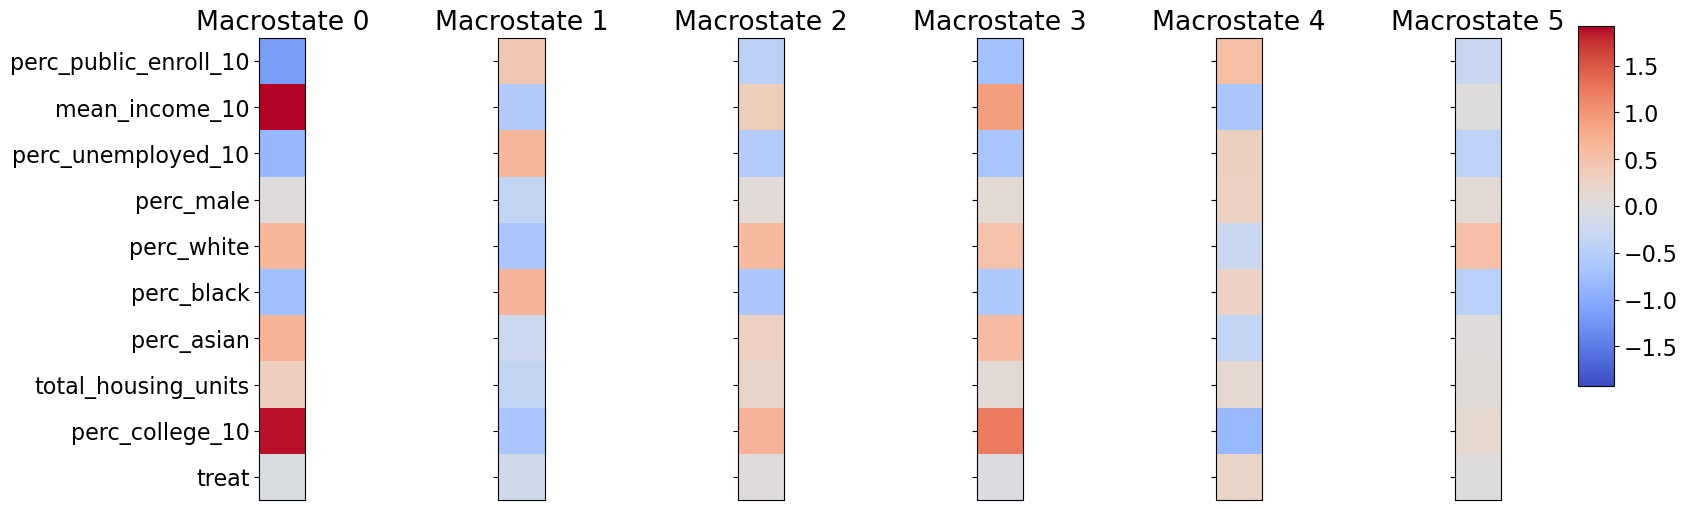

In [835]:
# visualize cause side macrostates
column = feature_cols + ['treat']
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause', 
                        exp_path='demo_results/experiment0003', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

In [836]:
data_cluster['cluster'].value_counts()

1    276
4    271
2    124
5    103
3    102
0     98
Name: cluster, dtype: int64

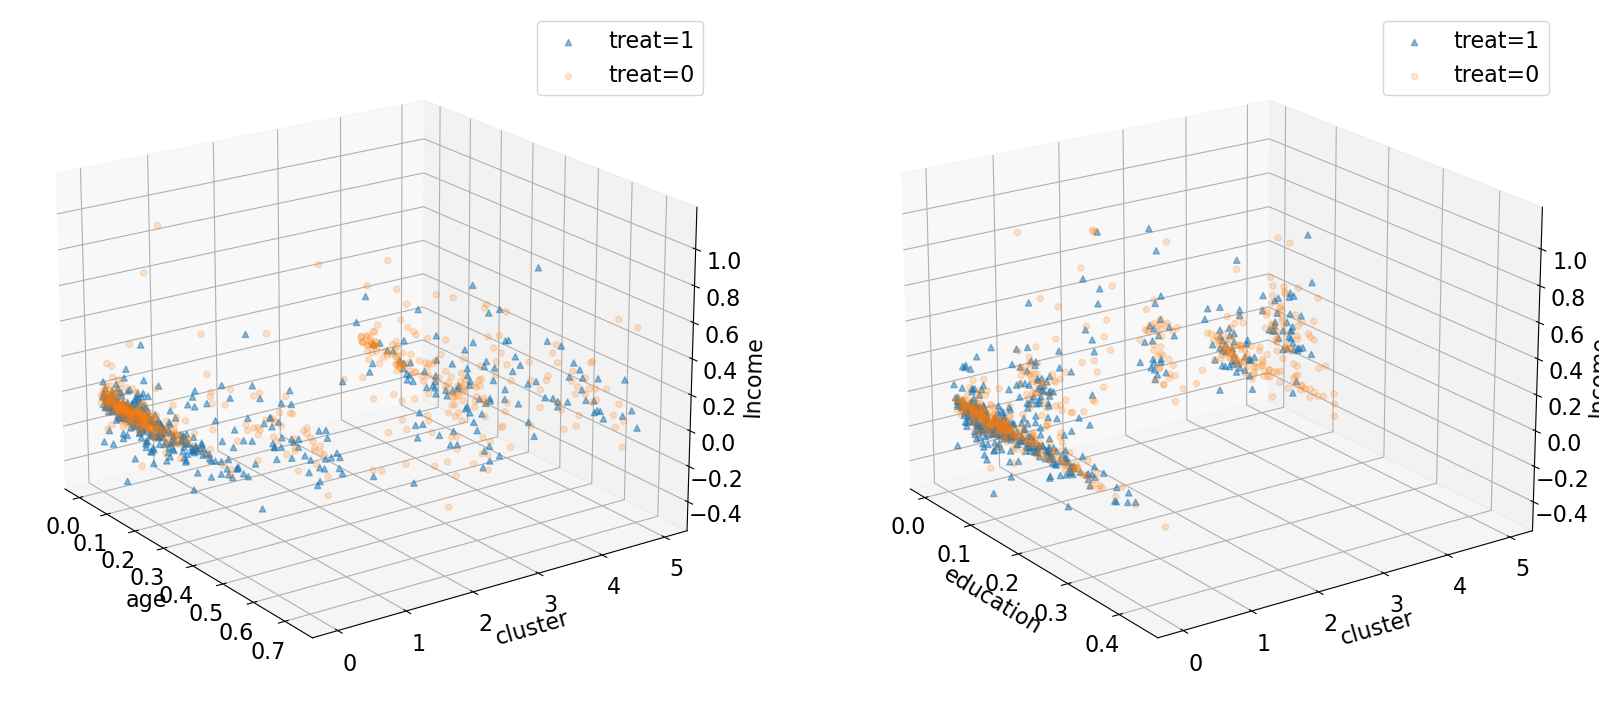

In [781]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,40))

ax = fig.add_subplot(1, 2, 1,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_college_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_med_value'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_college_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_med_value'], marker = 'o', label = 'treat=0', alpha = 0.2)
# Set y-axis to multiples of 10
# ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks(np.arange(0,6,1))
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income')
ax.view_init(elev=20, azim=-35)
ax.legend()

ax = fig.add_subplot(1, 2, 2,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_unemployed_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_med_value'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_unemployed_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_med_value'], marker = 'o', label = 'treat=0', alpha = 0.2)
ax.set_yticks(np.arange(0,6,1))
# ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-35)
ax.legend()
plt.show()


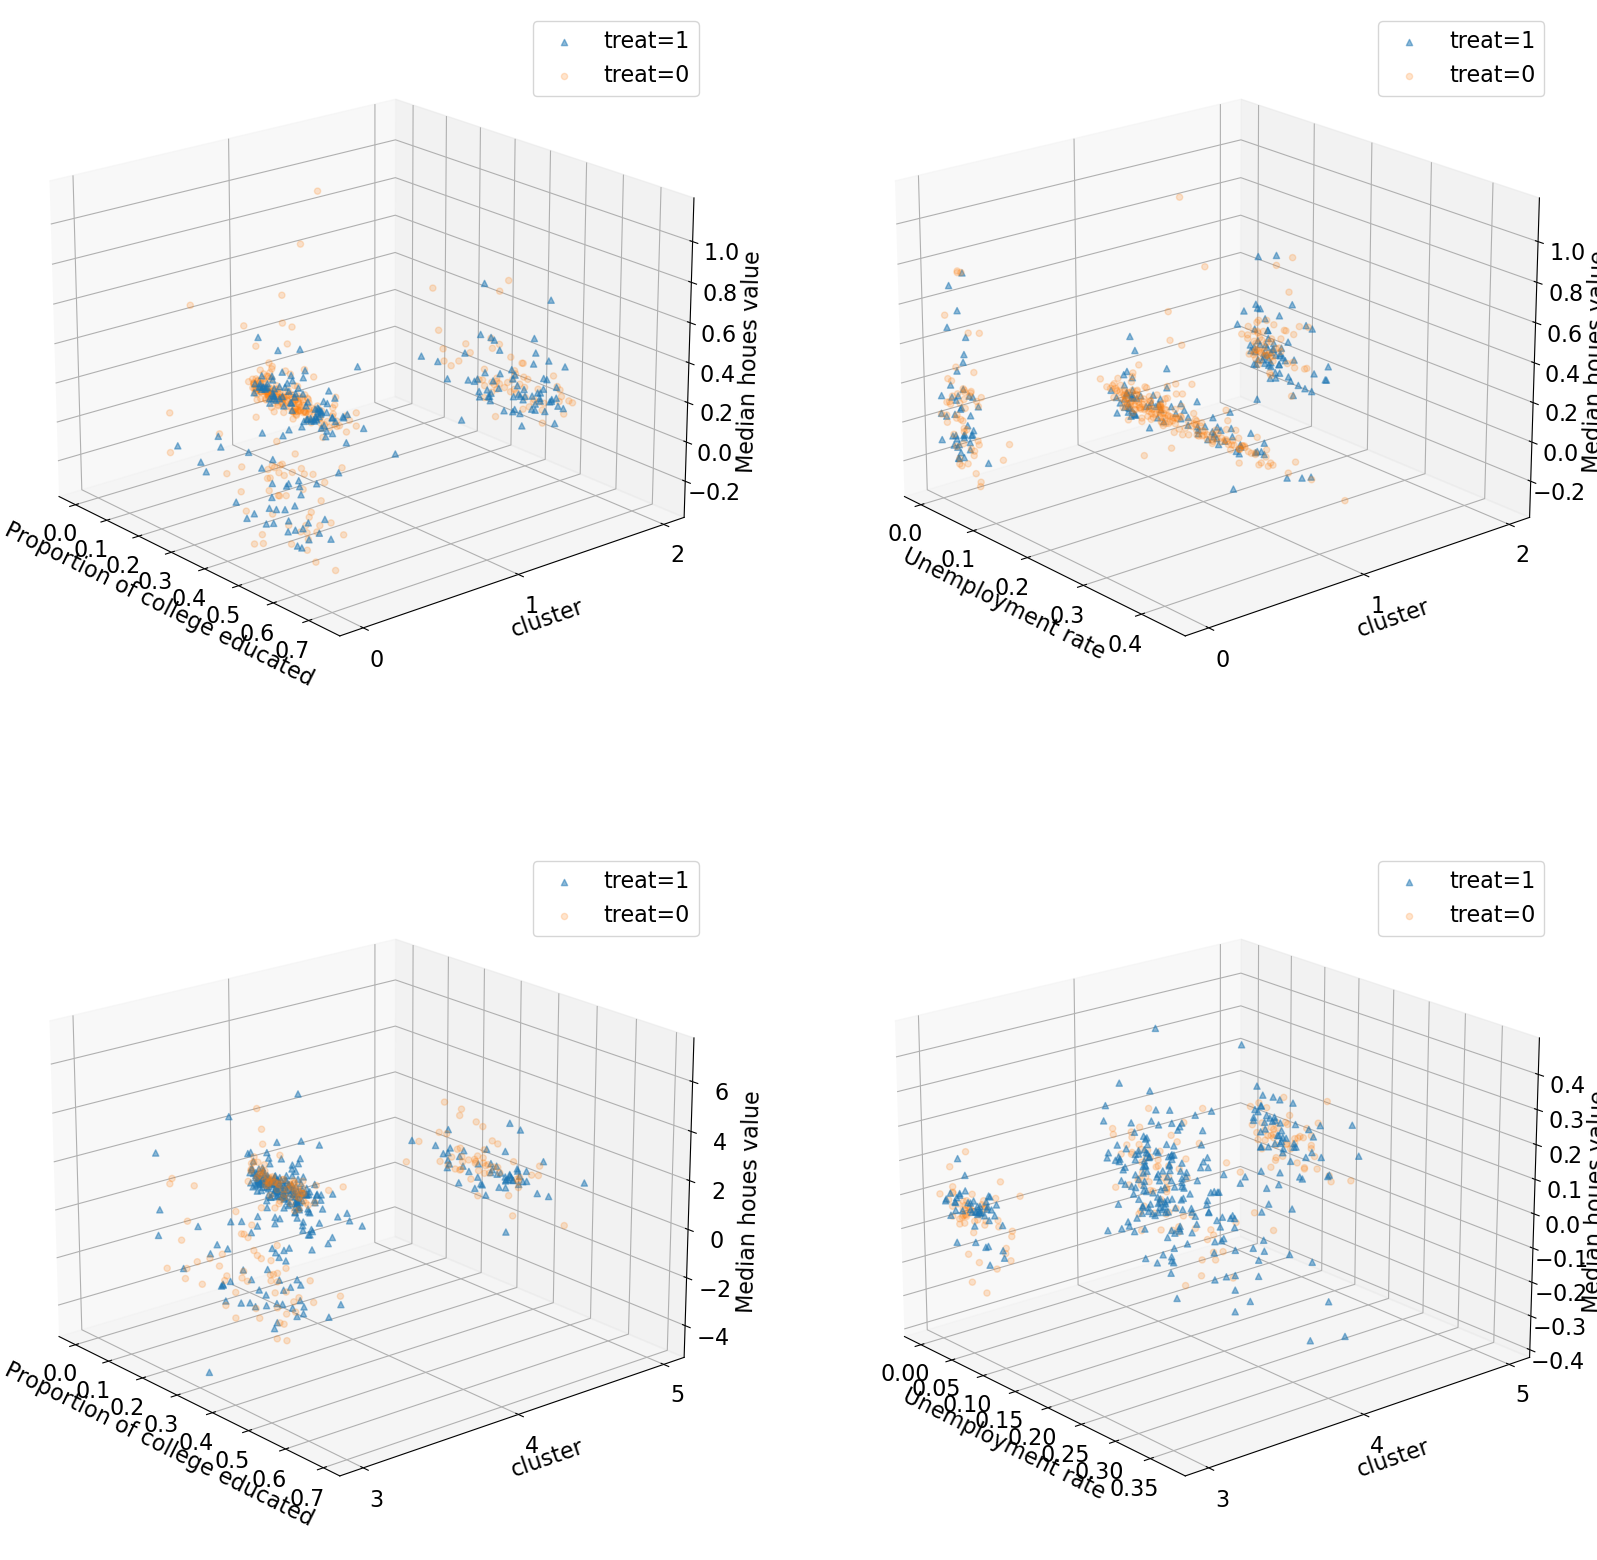

In [837]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,20))

##
# First Row
##

ax = fig.add_subplot(2, 2, 1,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['d_med_value'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['d_med_value'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks(np.arange(0,3,1))
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('Proportion of college educated')
ax.set_ylabel('cluster')
ax.set_zlabel('Median houes value')
ax.view_init(elev=20, azim=-40)
ax.legend()



ax = fig.add_subplot(2, 2, 2,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']<=2)]['d_med_value'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']<=2)]['d_med_value'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

ax.set_yticks(np.arange(0,3,1))
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('Unemployment rate')
ax.set_ylabel('cluster')
ax.set_zlabel('Median houes value')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-40)
ax.legend()


##
# Second Row
##


ax = fig.add_subplot(2, 2, 3,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['d_med_value'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['perc_college_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['d_med_value'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

# Set y-axis to multiples of 10
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks(np.arange(3,6,1))
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('Proportion of college educated')
ax.set_ylabel('cluster')
ax.set_zlabel('Median houes value')
ax.view_init(elev=20, azim=-40)
ax.legend()



ax = fig.add_subplot(2, 2, 4,projection='3d')
ax.scatter(data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==1)&(data_cluster['cluster']>2)]['d_perc_poverty'], 
           marker = '^', label = 'treat=1', alpha = 0.5)

ax.scatter(data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['perc_unemployed_10'],
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['cluster'], 
           data_cluster[(data_cluster['treat']==0)&(data_cluster['cluster']>2)]['d_perc_poverty'], 
           marker = 'o', label = 'treat=0', alpha = 0.2)

ax.set_yticks(np.arange(3,6,1))
ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('Unemployment rate')
ax.set_ylabel('cluster')
ax.set_zlabel('Median houes value')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-40)
ax.legend()


plt.savefig('value_unemployment_college_12_cl.png')
plt.show()


#### 12 Clusters

All results from this run will be saved to demo_results\experiment0007
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


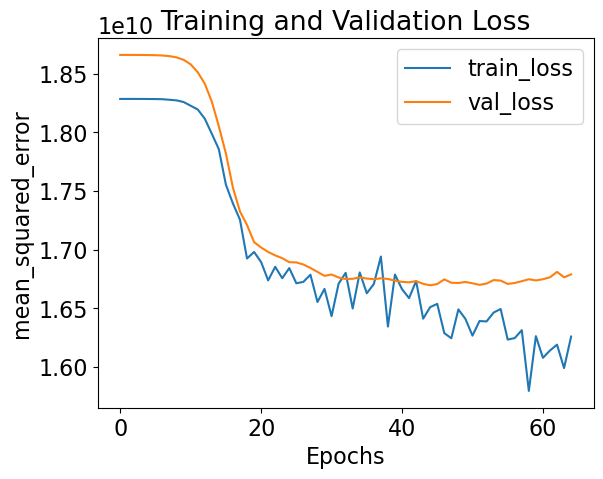

31/31 [==============================] - 0s 5ms/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [782]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'continuous'}

CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_model,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'learning_rate' : study.best_trial.params['learning_rate']},
        'loss'            : 'mean_squared_error',
        'best'            : True,
        'verbose'         : 0,
        'early_stopping'  : True
    }
}

cause_cluster_params =  {'model' : 'KMeans', 'model_params' : {'n_clusters' : 12},
        'verbose' : 0}
# effect_cluster_params = {'model' : 'KMeans', 'model_params' : {'n_clusters' : 3},
#     'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info,
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params,
                    results_path='demo_results')

train_results = my_exp.train()

import pandas as pd


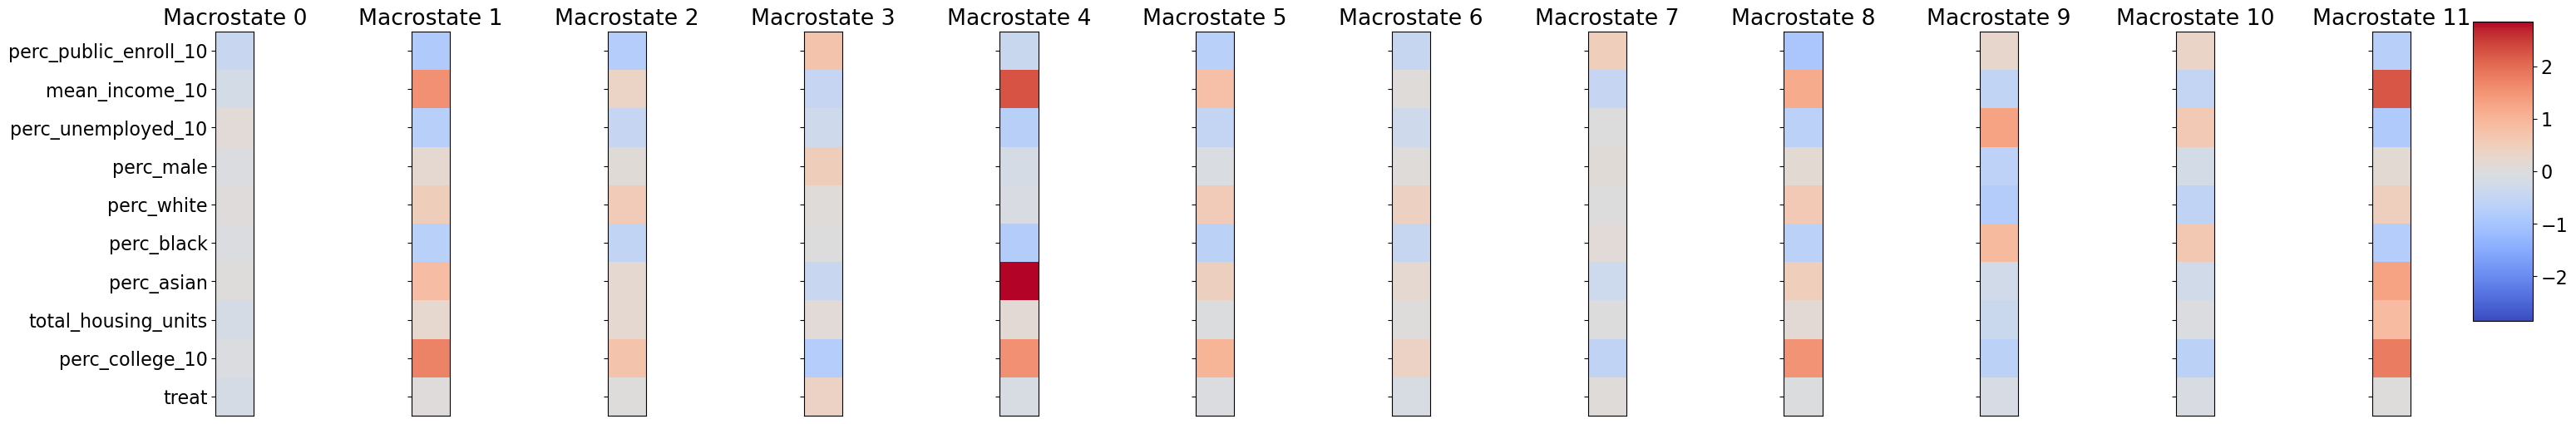

In [783]:
temp = data_final_unstandardized.loc[data_macthed.reset_index()['geoid']]
data_cluster = pd.merge(temp.reset_index(drop=True), pd.DataFrame(train_results['CauseClusterer']['x_lbls']), left_index=True, right_index=True).rename(columns={0:'cluster'})

# visualize cause side macrostates
column = feature_cols + ['treat']
from cfl.visualization.basic_visualizations import visualize_macrostates
visualize_macrostates(  data=X, # data to visualize
                        feature_names=column, # names of the features
                        cause_or_effect='cause',
                        exp_path='demo_results/experiment0007', # where was the data saved?
                        data_series='dataset_train', # if you've passed multiple datasets through CFL's predict method, you can select which one you want
                        subtract_global_mean=True) # do you want to plot the raw data or relative to the global mean?

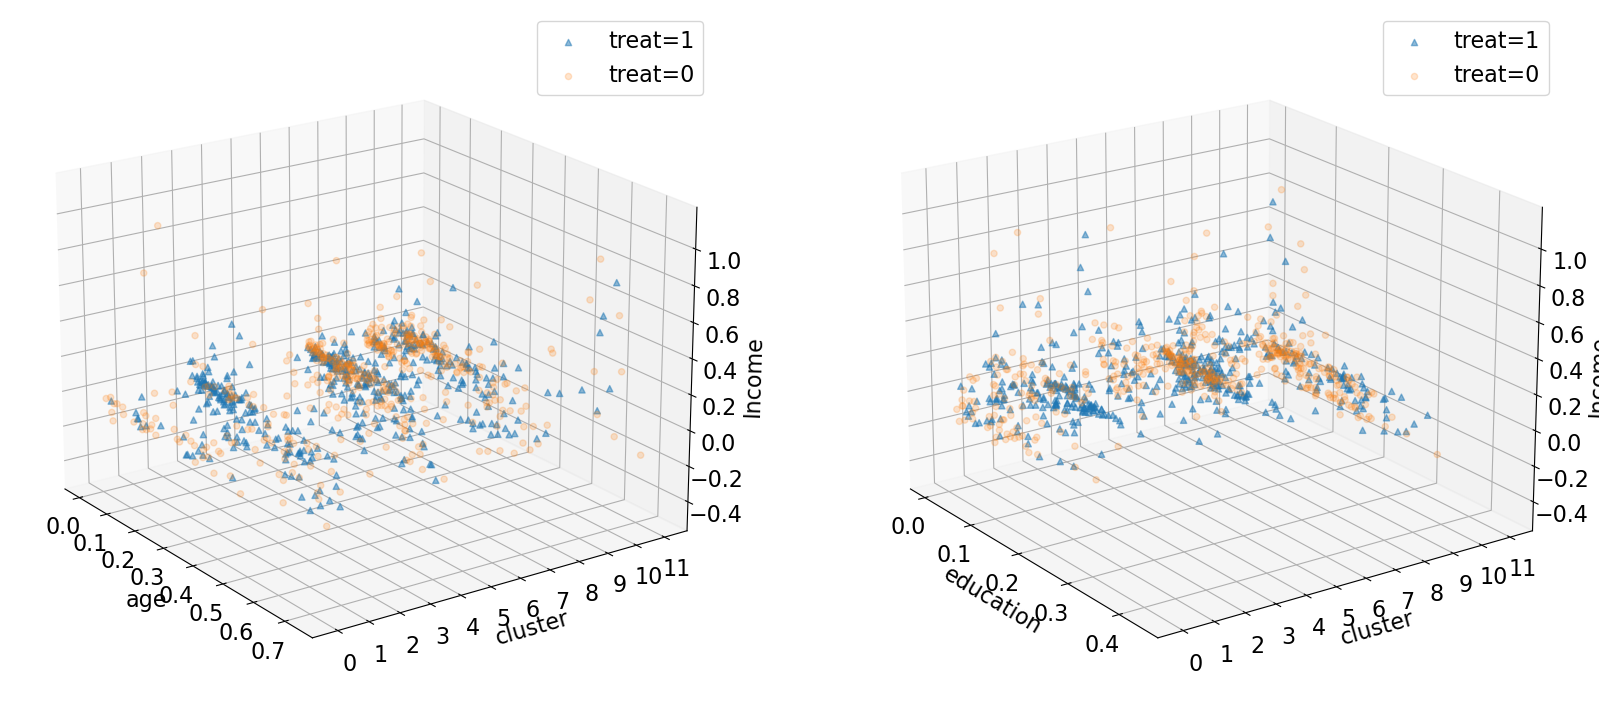

In [785]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,40))

ax = fig.add_subplot(1, 2, 1,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_college_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_med_value'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_college_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_med_value'], marker = 'o', label = 'treat=0', alpha = 0.2)
# Set y-axis to multiples of 10
# ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
# ax.scatter(data_cluster['age'],data_cluster['cluster'], data_cluster['rediff'],  c = data_cluster['treat'])
ax.set_yticks(np.arange(0,12,1))
# ax.set_xticks(range(20,60,10))
ax.set_xlabel('age')
ax.set_ylabel('cluster')
ax.set_zlabel('Income')
ax.view_init(elev=20, azim=-35)
ax.legend()

ax = fig.add_subplot(1, 2, 2,projection='3d')
ax.scatter(data_cluster[data_cluster['treat']==1]['perc_unemployed_10'],data_cluster[data_cluster['treat']==1]['cluster'], data_cluster[data_cluster['treat']==1]['d_med_value'], marker = '^', label = 'treat=1', alpha = 0.5)
ax.scatter(data_cluster[data_cluster['treat']==0]['perc_unemployed_10'],data_cluster[data_cluster['treat']==0]['cluster'], data_cluster[data_cluster['treat']==0]['d_med_value'], marker = 'o', label = 'treat=0', alpha = 0.2)
ax.set_yticks(np.arange(0,12,1))
# ax.ticklabel_format(axis='z', style='sci', scilimits=(-3,4))
# label that it is scientific notation
# ax.zaxis.major.formatter._useMathText = True
ax.set_xlabel('education')
ax.set_ylabel('cluster')
ax.set_zlabel('Income')
# ax.set_xticks(range(0,16,4))
ax.view_init(elev=20, azim=-35)
ax.legend()

plt.show()


## Rate of house occupancy

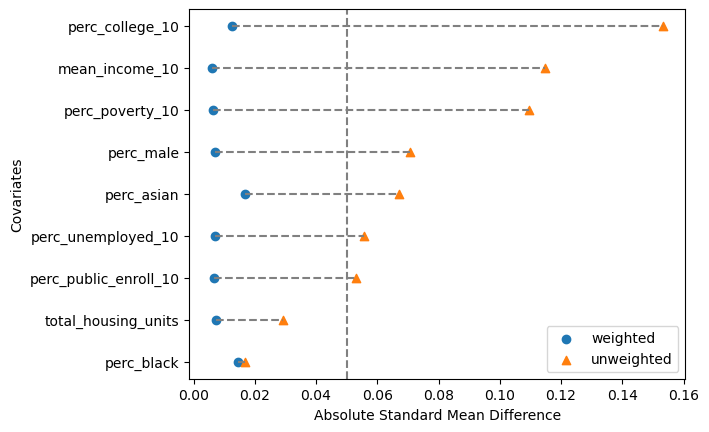

IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.4/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=5000, solver='liblinear'))

In [299]:
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from causallib.datasets import load_nhefs
import matplotlib.pyplot as plt
# import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# standardize the data
scaler = StandardScaler()
data_final[feature_cols] = scaler.fit_transform(data_final[feature_cols])

ipw = IPW(LogisticRegression(solver="liblinear", max_iter=5000))

results1 = evaluate(ipw, data_final[feature_cols], data_final['treat'], data_final[outcome[1]], cv="auto")
ax = plt.gca()
# results1.plot_covariate_balance(kind="love", ax=ax, thresh=0.05)

# plt.show()

ipw.fit(data_final[feature_cols], data_final['treat'])

In [270]:
outcomes = ipw.estimate_population_outcome(data_final[feature_cols], data_final['treat'], data_final[outcome[1]])
effect = ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=["diff"])
effect

diff   -0.000985
dtype: float64

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

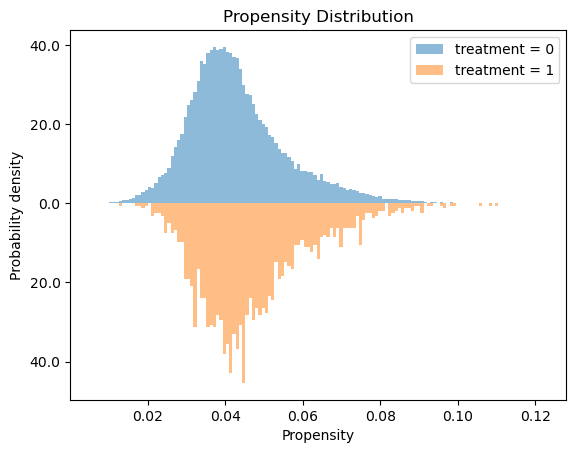

In [271]:
results1.plot_weight_distribution()

In [276]:
weights = ipw.compute_weights(data_final[feature_cols], data_final['treat'])
data_final['weights'] = weights
data_final.groupby('treat')['weights'].sum()

treat
0    11351.330690
1    11239.076066
Name: weights, dtype: float64

In [296]:
# multiply the weights by each feature
data_adjusted = data_final[feature_cols].multiply(data_final['weights'], axis=0)
data_adjusted['treat'] = data_final['treat']
